In [111]:

import numpy as np
import glob, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pandas import set_option
pd.set_option('display.max_columns', None)

Le chargement prendra environ 4 minutes (fichiers volumineux). il faut faire "parcourir" et envoyer en meme temps les trois fichiers fournis dans le projet.

In [112]:
from google.colab import files
import pandas as pd

# Install des dependances
!pip install pyxlsb

# Upload des fichiers
uploaded = files.upload()

# Définir les noms des fichiers
files_to_process = {
    "VideoGame_Sales_1980-2016.xlsb": {"sheet": "vgsales", "engine": "pyxlsb"},
    "All_publish_VideoGame_2022.xlsb": {"sheet": None, "engine": "pyxlsb"},  # None = première feuille
    "Vente+de+console_2022.xlsx": {"sheet": None, "engine": "openpyxl"}  # xlsx utilise openpyxl
}

# Dictionnaire pour stocker les DataFrames
dataframes = {}

# Traiter chaque fichier
for file_name, config in files_to_process.items():
    if file_name in uploaded:
        try:
            if config["sheet"]:
                df = pd.read_excel(file_name, engine=config["engine"], sheet_name=config["sheet"])
            else:
                df = pd.read_excel(file_name, engine=config["engine"])

            # Stocker le DataFrame avec un nom simplifié
            df_name = file_name.replace(".xlsb", "").replace(".xlsx", "").replace("+", "_")
            dataframes[df_name] = df

            print(f"Fichier '{file_name}' chargé avec succès")
            print(f"  Forme: {df.shape}")
            display(df.head())
            print("-" * 50)

        except Exception as e:
            print(f" Erreur avec '{file_name}': {e}")
    else:
        print(f" Fichier '{file_name}' non trouvé dans l'upload")




Saving All_publish_VideoGame_2022.xlsb to All_publish_VideoGame_2022 (1).xlsb
Saving Vente+de+console_2022.xlsx to Vente+de+console_2022 (1).xlsx
Saving VideoGame_Sales_1980-2016.xlsb to VideoGame_Sales_1980-2016 (1).xlsb
 Fichier 'VideoGame_Sales_1980-2016.xlsb' non trouvé dans l'upload
 Fichier 'All_publish_VideoGame_2022.xlsb' non trouvé dans l'upload
 Fichier 'Vente+de+console_2022.xlsx' non trouvé dans l'upload


In [113]:
# Accéder aux DataFrames individuellement
if "VideoGame_Sales_1980-2016" in dataframes:
    df_sales = dataframes["VideoGame_Sales_1980-2016"]

if "All_publish_VideoGame_2022" in dataframes:
    df_allvg = dataframes["All_publish_VideoGame_2022"]

if "Vente_de_console_2022" in dataframes:
    df_console = dataframes["Vente_de_console_2022"]

print(f"\nDataFrames disponibles : {list(dataframes.keys())}")


DataFrames disponibles : []


on va recuperer un dataset un peu plus a jour sur kaggle et le fusionner, meme si depuis 2020 on a plus trop d'informations publiques disponibles sur les ventes.

In [114]:
import kagglehub
path = kagglehub.dataset_download("asaniczka/video-game-sales-2024")
path  # dossier local du dataset

csvs = glob.glob(path + "/**/*.csv", recursive=True)
assert csvs, "Aucun CSV trouvé. Vérifie le contenu du dataset."
df2024 = pd.read_csv(csvs[0])
df2024.head()
# Supprimer les lignes où 'release_date' est vide
df2024.dropna(subset=['release_date'], inplace=True)

# Convert 'release_date' to datetime, extract the year, handle NaNs, et convert to integer
df2024['Année'] = pd.to_datetime(df2024['release_date'], errors='coerce').dt.year.fillna(0).astype(int)
df2024 = df2024.drop(columns=['release_date', 'img', 'last_update'])

df2024.head(500)

,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,Année
0,Grand Theft Auto V,PS3,Action,Rockstar Games,Rockstar North,9.4,20.32,6.37,0.99,9.85,3.12,2013
1,Grand Theft Auto V,PS4,Action,Rockstar Games,Rockstar North,9.7,19.39,6.06,0.60,9.71,3.02,2014
2,Grand Theft Auto: Vice City,PS2,Action,Rockstar Games,Rockstar North,9.6,16.15,8.41,0.47,5.49,1.78,2002
3,Grand Theft Auto V,X360,Action,Rockstar Games,Rockstar North,NaN,15.86,9.06,0.06,5.33,1.42,2013
4,Call of Duty: Black Ops 3,PS4,Shooter,Activision,Treyarch,8.1,15.09,6.18,0.41,6.05,2.44,2015
...,...,...,...,...,...,...,...,...,...,...,...,...
495,Toy Story 3: The Video Game,DS,Action,Disney Interactive Studios,Avalanche Software,NaN,2.06,0.89,0.02,0.95,0.21,2010
496,Hitman: Absolution,PS3,Action,Square Enix,IO Interactive,NaN,2.06,0.59,0.07,1.08,0.32,2012
497,Tom Clancy's Splinter Cell: Conviction,X360,Action,Ubisoft,Ubisoft Montreal,8.6,2.06,1.20,0.04,0.62,0.19,2010
498,Need for Speed: Undercover,PS3,Racing,Electronic Arts,EA Vancouver,5.9,2.06,0.63,0.05,1.01,0.38,2008


# Preparation des données

In [115]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16817 entries, 0 to 16816
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16817 non-null  int64  
 1   Name          16817 non-null  object 
 2   Platform      16817 non-null  object 
 3   Year          16817 non-null  float64
 4   Genre         16817 non-null  object 
 5   Publisher     16759 non-null  object 
 6   Constructeur  16817 non-null  object 
 7   Portable      16817 non-null  object 
 8   NA_Sales      16817 non-null  float64
 9   EU_Sales      16817 non-null  float64
 10  JP_Sales      16817 non-null  float64
 11  Other_Sales   16817 non-null  float64
 12  Global_Sales  16817 non-null  float64
dtypes: float64(6), int64(1), object(6)
memory usage: 1.7+ MB


In [116]:
df_sales.describe()

,Rank,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,16817.000000,16817.000000,16817.000000,16817.000000,16817.000000,16817.000000,16817.000000
mean,8188.960219,1998.445918,0.275957,0.150508,0.080454,0.048648,0.555567
std,4817.192982,123.686262,0.857662,0.567796,0.309386,0.215060,1.671623
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3936.000000,2003.000000,0.000000,0.000000,0.000000,0.000000,0.061000
50%,8149.000000,2007.000000,0.081600,0.021000,0.000000,0.010000,0.178700
75%,12367.000000,2010.000000,0.257500,0.121200,0.040400,0.031500,0.510000
max,16600.000000,2020.000000,41.490000,27.859200,9.811200,12.098600,81.296900


pas de données hors scope, on va par contre changer les années en entier, et metrte a 0 les vides


In [117]:
# convertit la colonne 'Year' en integer +
df_sales['Year'] = df_sales['Year'].fillna(0).astype(int)


pour les années vide on va d'abord regarder s'il n'y a pas l'année de renseignée pour le meme jeu mais sur une autre plateforme

In [118]:
# affiche les lignes où 'Year' est à 0
display(df_sales[df_sales['Year'] == 0])
print(f" Nombre de lignes sans années : {df_sales[df_sales['Year'] == 0].shape[0]}")

,Rank,Name,Platform,Year,Genre,Publisher,Constructeur,Portable,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
1233,1305,Triple Play 99,PS,0,Sports,NaN,Sony,Non,0.8424,0.5775,0.0000,0.1050,1.5249
1554,1515,Adventure,2600,0,Adventure,Atari,Atati,Non,1.1858,0.0840,0.0000,0.0101,1.2799
1965,1992,Legacy of Kain: Soul Reaver,PS,0,Action,Eidos Interactive,Sony,Non,0.5684,0.4160,0.0000,0.0700,1.0544
2338,2021,Donkey Kong Land III,GB,0,Platform,Nintendo,Nintendo,Oui,0.6528,0.3162,0.0000,0.0404,1.0094
2480,2115,Air-Sea Battle,2600,0,Shooter,Atari,Atati,Non,0.8736,0.0618,0.0000,0.0097,0.9451
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15660,15000,Wii de Asobu: Metroid Prime,Wii,0,Shooter,Nintendo,Nintendo,Non,0.0000,0.0000,0.0198,0.0000,0.0198
15874,14945,Umineko no Naku Koro ni San: Shinjitsu to Gens...,PS3,0,Adventure,NaN,Sony,Non,0.0000,0.0000,0.0194,0.0000,0.0194
16009,15479,Yu-Gi-Oh! 5D's Wheelie Breakers (JP sales),Wii,0,Racing,Unknown,Nintendo,Non,0.0000,0.0000,0.0192,0.0000,0.0192
16345,16369,Hakuouki: Shinsengumi Kitan,PS3,0,Adventure,Unknown,Sony,Non,0.0102,0.0000,0.0000,0.0000,0.0102


 Nombre de lignes sans années : 64


In [119]:
# regrouper par nom de jeu et remplir les années manquantes (où l'année est 0)
df_sales['Year'] = df_sales.groupby('Name')['Year'].transform(lambda x: x.replace(0, x[x != 0].iloc[0] if not x[x != 0].empty else 0))

# Afficher les lignes où « Année » est encore égal à 0
display(df_sales[df_sales['Year'] == 0])
print(f" Nombre de lignes sans années : {df_sales[df_sales['Year'] == 0].shape[0]}")

,Rank,Name,Platform,Year,Genre,Publisher,Constructeur,Portable,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
1233,1305,Triple Play 99,PS,0,Sports,NaN,Sony,Non,0.8424,0.5775,0.0000,0.1050,1.5249
1554,1515,Adventure,2600,0,Adventure,Atari,Atati,Non,1.1858,0.0840,0.0000,0.0101,1.2799
1965,1992,Legacy of Kain: Soul Reaver,PS,0,Action,Eidos Interactive,Sony,Non,0.5684,0.4160,0.0000,0.0700,1.0544
2338,2021,Donkey Kong Land III,GB,0,Platform,Nintendo,Nintendo,Oui,0.6528,0.3162,0.0000,0.0404,1.0094
2480,2115,Air-Sea Battle,2600,0,Shooter,Atari,Atati,Non,0.8736,0.0618,0.0000,0.0097,0.9451
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15660,15000,Wii de Asobu: Metroid Prime,Wii,0,Shooter,Nintendo,Nintendo,Non,0.0000,0.0000,0.0198,0.0000,0.0198
15874,14945,Umineko no Naku Koro ni San: Shinjitsu to Gens...,PS3,0,Adventure,NaN,Sony,Non,0.0000,0.0000,0.0194,0.0000,0.0194
16009,15479,Yu-Gi-Oh! 5D's Wheelie Breakers (JP sales),Wii,0,Racing,Unknown,Nintendo,Non,0.0000,0.0000,0.0192,0.0000,0.0192
16345,16369,Hakuouki: Shinsengumi Kitan,PS3,0,Adventure,Unknown,Sony,Non,0.0102,0.0000,0.0000,0.0000,0.0102


 Nombre de lignes sans années : 64


In [120]:
# Créer un DataFrame temporaire avec seulement les colonnes Name et Annee de df_allvg
df_allvg_years = df_allvg[['name', 'Annee']].copy()

# Créer des colonnes temporaires en minuscules pour la correspondance
df_allvg_years['name_lower'] = df_allvg_years['name'].str.lower()
df_sales['Name_lower'] = df_sales['Name'].str.lower()

# Fusionner df_sales avec df_allvg_years basé sur le nom du jeu en minuscules
# Utiliser un left merge pour conserver toutes les lignes de df_sales
df_sales = df_sales.merge(df_allvg_years, left_on='Name_lower', right_on='name_lower', how='left')

# Mettre à jour 'Year' dans df_sales seulement où 'Year' est 0 et une correspondance a été trouvée dans df_allvg
df_sales['Year'] = df_sales.apply(
    lambda row: row['Annee'] if row['Year'] == 0 and not pd.isna(row['Annee']) else row['Year'],
    axis=1
)

# Supprimer les colonnes temporaires du merge
df_sales = df_sales.drop(columns=['name', 'Annee', 'name_lower', 'Name_lower'])

# Afficher les lignes où 'Year' était originalement 0 pour voir si certaines ont été mises à jour
display(df_sales[df_sales['Year'] == 0])
print(f" Nombre de lignes sans années : {df_sales[df_sales['Year'] == 0].shape[0]}")

,Rank,Name,Platform,Year,Genre,Publisher,Constructeur,Portable,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
1233,1305,Triple Play 99,PS,0,Sports,NaN,Sony,Non,0.8424,0.5775,0.0000,0.1050,1.5249
1554,1515,Adventure,2600,0,Adventure,Atari,Atati,Non,1.1858,0.0840,0.0000,0.0101,1.2799
1965,1992,Legacy of Kain: Soul Reaver,PS,0,Action,Eidos Interactive,Sony,Non,0.5684,0.4160,0.0000,0.0700,1.0544
76594,2021,Donkey Kong Land III,GB,0,Platform,Nintendo,Nintendo,Oui,0.6528,0.3162,0.0000,0.0404,1.0094
76736,2115,Air-Sea Battle,2600,0,Shooter,Atari,Atati,Non,0.8736,0.0618,0.0000,0.0097,0.9451
...,...,...,...,...,...,...,...,...,...,...,...,...,...
89916,15000,Wii de Asobu: Metroid Prime,Wii,0,Shooter,Nintendo,Nintendo,Non,0.0000,0.0000,0.0198,0.0000,0.0198
90130,14945,Umineko no Naku Koro ni San: Shinjitsu to Gens...,PS3,0,Adventure,NaN,Sony,Non,0.0000,0.0000,0.0194,0.0000,0.0194
90265,15479,Yu-Gi-Oh! 5D's Wheelie Breakers (JP sales),Wii,0,Racing,Unknown,Nintendo,Non,0.0000,0.0000,0.0192,0.0000,0.0192
90601,16369,Hakuouki: Shinsengumi Kitan,PS3,0,Adventure,Unknown,Sony,Non,0.0102,0.0000,0.0000,0.0000,0.0102


 Nombre de lignes sans années : 64


on va rechercher dans le nom du jeu s'il ne mentionne pas l'année et le renseigner

In [121]:
import re

def extract_year_from_name(row):
    if row['Year'] == 0:
        match = re.search(r'\b(19|20)\d{2}\b', row['Name'])
        if match:
            return int(match.group(0))
    return row['Year']

df_sales['Year'] = df_sales.apply(extract_year_from_name, axis=1)
display(df_sales[df_sales['Year'] == 0])
print(f" Nombre de lignes sans années : {df_sales[df_sales['Year'] == 0].shape[0]}")

,Rank,Name,Platform,Year,Genre,Publisher,Constructeur,Portable,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
1233,1305,Triple Play 99,PS,0,Sports,NaN,Sony,Non,0.8424,0.5775,0.0000,0.1050,1.5249
1554,1515,Adventure,2600,0,Adventure,Atari,Atati,Non,1.1858,0.0840,0.0000,0.0101,1.2799
1965,1992,Legacy of Kain: Soul Reaver,PS,0,Action,Eidos Interactive,Sony,Non,0.5684,0.4160,0.0000,0.0700,1.0544
76594,2021,Donkey Kong Land III,GB,0,Platform,Nintendo,Nintendo,Oui,0.6528,0.3162,0.0000,0.0404,1.0094
76736,2115,Air-Sea Battle,2600,0,Shooter,Atari,Atati,Non,0.8736,0.0618,0.0000,0.0097,0.9451
...,...,...,...,...,...,...,...,...,...,...,...,...,...
89916,15000,Wii de Asobu: Metroid Prime,Wii,0,Shooter,Nintendo,Nintendo,Non,0.0000,0.0000,0.0198,0.0000,0.0198
90130,14945,Umineko no Naku Koro ni San: Shinjitsu to Gens...,PS3,0,Adventure,NaN,Sony,Non,0.0000,0.0000,0.0194,0.0000,0.0194
90265,15479,Yu-Gi-Oh! 5D's Wheelie Breakers (JP sales),Wii,0,Racing,Unknown,Nintendo,Non,0.0000,0.0000,0.0192,0.0000,0.0192
90601,16369,Hakuouki: Shinsengumi Kitan,PS3,0,Adventure,Unknown,Sony,Non,0.0102,0.0000,0.0000,0.0000,0.0102


 Nombre de lignes sans années : 64


on va rajouter les données suppémentaires issuent de kaggle

In [122]:
cols = [
    'Name','Platform','Genre','Publisher','Constructeur',
    'NA_Sales','EU_Sales','JP_Sales','Other_Sales','Global_Sales','Year'
]
df_sales2 = df_sales[cols].copy()

df2024.rename(columns={
    'title': 'Name',
    'console': 'Platform',
    'genre': 'Genre',
    'publisher': 'Publisher',
    'developer': 'Constructeur',
    'na_sales': 'NA_Sales',
    'pal_sales': 'EU_Sales',
    'jp_sales': 'JP_Sales',
    'other_sales': 'Other_Sales',
    'total_sales': 'Global_Sales',
    'Année': 'Year'
}, inplace=True)
#suppression de la colonne Rank de df_sales2
df_salesGlobal = pd.concat([df_sales2, df2024], ignore_index=True)
df_salesGlobal['Year'] = df_salesGlobal['Year'].fillna(0).astype(int)
#on tri par Year
df_salesGlobal = df_salesGlobal.sort_values(by='Year').reset_index(drop=True)
df_salesGlobal.head(2000)

,Name,Platform,Genre,Publisher,Constructeur,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Year,critic_score
0,Triple Play 99,PS,Sports,NaN,Sony,0.8424,0.5775,0.0000,0.1050,1.5249,0,NaN
1,Charm Girls Club: My Fashion Show,DS,Simulation,Unknown,Nintendo,0.0784,0.0000,0.0000,0.0102,0.0886,0,NaN
2,Adventure,2600,Adventure,Atari,Atati,1.1858,0.0840,0.0000,0.0101,1.2799,0,NaN
3,Super Puzzle Fighter II,GBA,Puzzle,Capcom,Nintendo,0.0612,0.0194,0.0000,0.0000,0.0806,0,NaN
4,Combat Wings: The Great Battles of WWII,Wii,Simulation,City Interactive,Nintendo,0.0202,0.0000,0.0000,0.0000,0.0202,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1942,NES,Shooter,Capcom,Nintendo,0.6825,0.1470,0.2079,0.0000,1.0374,1985,NaN
1996,1942,NES,Shooter,Capcom,Nintendo,0.6825,0.1470,0.2079,0.0000,1.0374,1985,NaN
1997,1942,NES,Shooter,Capcom,Nintendo,0.6825,0.1470,0.2079,0.0000,1.0374,1985,NaN
1998,1942,NES,Shooter,Capcom,Nintendo,0.6825,0.1470,0.2079,0.0000,1.0374,1985,NaN


In [123]:
df_salesGlobal.to_csv('df_salesGlobal.csv', index=False, sep=';')
print("df_salesGlobal.csv exported successfully.")

from google.colab import files
files.download('df_salesGlobal.csv')

df_salesGlobal.csv exported successfully.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

note fichier global est a présent plus complet.

# VENTES TOTALES PAR ANNEES

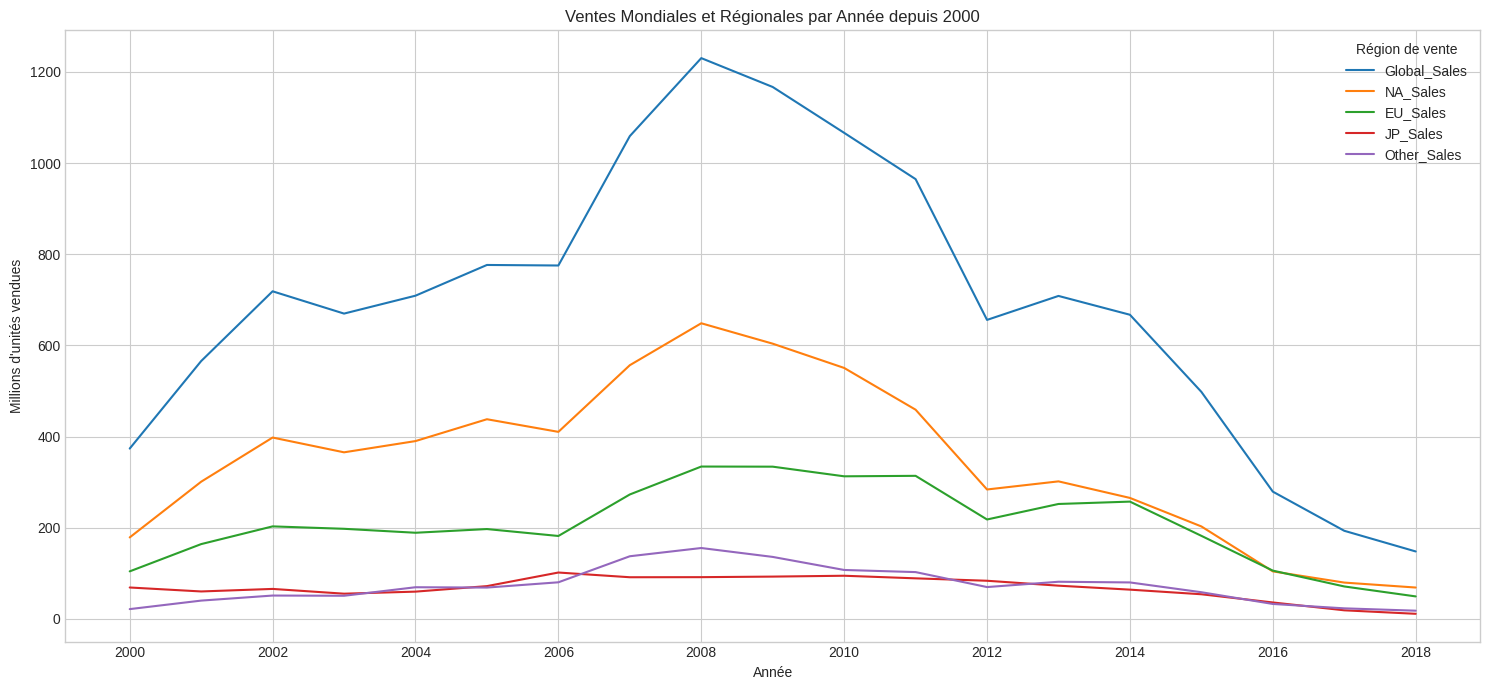

In [124]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker # Importer le module ticker

# préparation des données
sales_by_year = df_salesGlobal.groupby('Year')[['Global_Sales', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum()
sales_by_year = sales_by_year[(sales_by_year.index >= 2000) & (sales_by_year.index <= 2018)]
sales_by_year.index = sales_by_year.index.astype(int)

# Créer le graphique
fig, ax = plt.subplots(figsize=(15, 7))
sales_by_year.plot(kind='line', ax=ax) # On spécifie de dessiner sur nos axes 'ax'

# Forcer les graduations de l'axe X à être des entiers
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

#  mise en forme
ax.set_title('Ventes Mondiales et Régionales par Année depuis 2000')
ax.set_xlabel('Année')
ax.set_ylabel('Millions d\'unités vendues')
ax.grid(True)
ax.legend(title='Région de vente')

plt.tight_layout()
plt.show()

In [125]:

from sklearn.linear_model import LinearRegression



# 1. PRÉPARATION DES DONNÉES ET PRÉDICTION
# Regrouper par année et additionner les colonnes des ventes
sales_by_year_full = df_salesGlobal.groupby('Year')[['Global_Sales', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum()

# filtre de 2000 à 2015 pour l'entraînement du modèle
sales_by_year_train = sales_by_year_full[(sales_by_year_full.index >= 2000) & (sales_by_year_full.index <= 2015)]

# Définir les années futures pour la prédiction
future_years = np.arange(2016, 2026)
predictions = {}

# Boucle pour prédire chaque colonne de ventes
for column in sales_by_year_train.columns:
    X = sales_by_year_train.index.values.reshape(-1, 1)
    y = sales_by_year_train[column].values

    model = LinearRegression()
    model.fit(X, y)

    future_X = future_years.reshape(-1, 1)
    predicted_sales = model.predict(future_X)
    predicted_sales[predicted_sales < 0] = 0
    predictions[column] = predicted_sales

# Création d'un DataFrame avec les prédictions
predictions_df = pd.DataFrame(predictions, index=future_years)


on va tenter de faire le graphique en ponderant au nombre de données valides

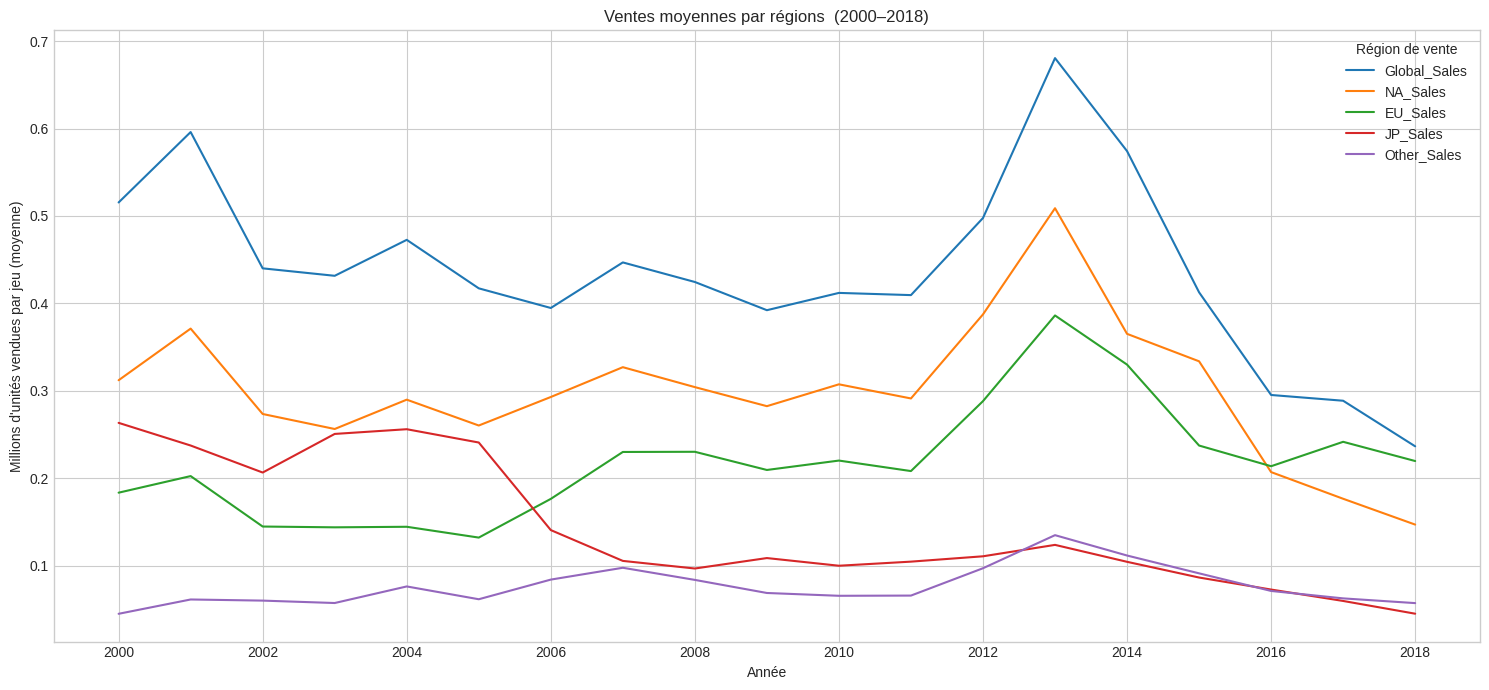

In [126]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Somme des ventes par année
sales_by_year = df_salesGlobal.groupby('Year')[['Global_Sales', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum()

# Nombre de jeux avec des ventes renseignées (non nulles ou >0)
counts_by_year = df_salesGlobal.groupby('Year')[['Global_Sales', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].apply(lambda x: (x > 0).sum())

# Moyenne pondérée = ventes totales / nb de jeux reportés
sales_weighted = sales_by_year / counts_by_year

# Filtrer la période
sales_weighted = sales_weighted[(sales_weighted.index >= 2000) & (sales_weighted.index <= 2018)]
sales_weighted.index = sales_weighted.index.astype(int)

# Graphique
fig, ax = plt.subplots(figsize=(15, 7))
sales_weighted.plot(kind='line', ax=ax)

# Axe X en entiers
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

# Mise en forme
ax.set_title('Ventes moyennes par régions  (2000–2018)')
ax.set_xlabel('Année')
ax.set_ylabel('Millions d\'unités vendues par jeu (moyenne)')
ax.grid(True)
ax.legend(title='Région de vente')

plt.tight_layout()
plt.show()


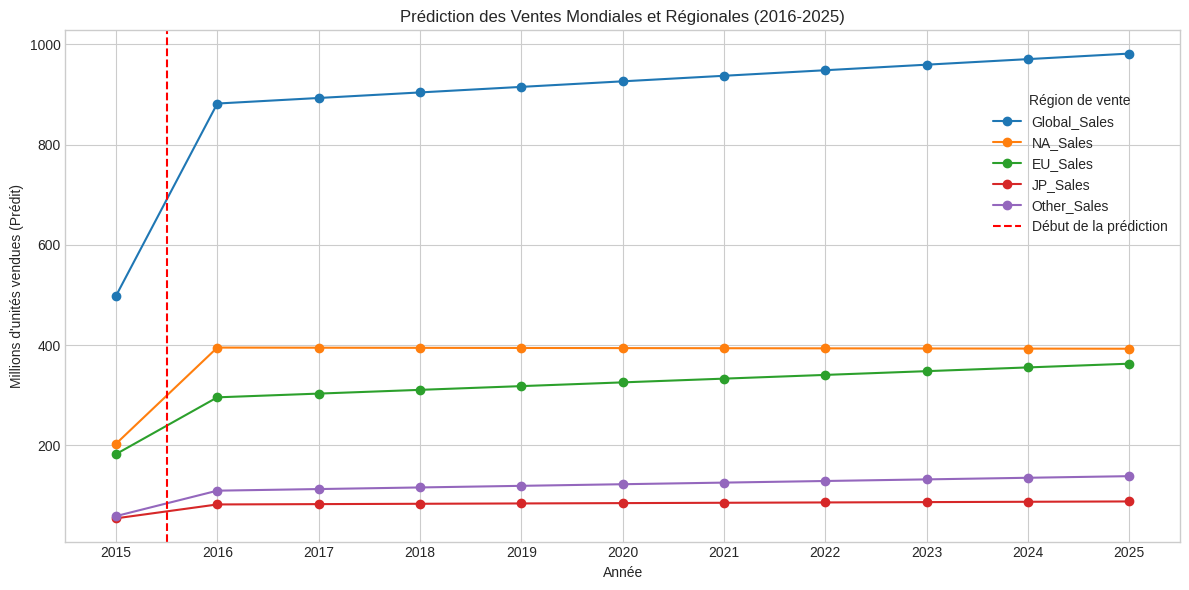

In [127]:

# Prédiction Uniquement (2015-2025)

# On combine le dernier point réel (2015) avec les prédictions pour un meilleur contexte
last_real_year_df = sales_by_year_train.loc[[2015]]
prediction_plot_df = pd.concat([last_real_year_df, predictions_df])

# Création de la figure pour le graphique de prédiction
plt.figure(figsize=(12, 6))

# Tracé des données combinées (2015 en réel + 2016-2025 en prédiction)
prediction_plot_df.plot(kind='line', marker='o', ax=plt.gca())

# Ligne verticale pour marquer la séparation
plt.axvline(x=2015.5, color='red', linestyle='--', label='Début de la prédiction')

# Titres et légendes
plt.title('Prédiction des Ventes Mondiales et Régionales (2016-2025)')
plt.xlabel('Année')
plt.ylabel('Millions d\'unités vendues (Prédit)')
plt.grid(True)
plt.legend(title='Région de vente')

plt.legend(title='Région de vente', bbox_to_anchor=(1, 0.9), loc='upper right')
# S'assurer que chaque année est affichée sur l'axe X
plt.xticks(prediction_plot_df.index)

plt.tight_layout()
plt.show()

# ANALYSE ALLVG2020

In [128]:
df_allvg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440896 entries, 0 to 440895
Data columns (total 67 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    440896 non-null  int64  
 1   slug                  440894 non-null  object 
 2   name                  440893 non-null  object 
 3   metacritic            4627 non-null    float64
 4   released              440896 non-null  int64  
 5   Annee                 440896 non-null  int64  
 6   tba                   440896 non-null  bool   
 7   rating                440833 non-null  float64
 8   rating_top            440833 non-null  float64
 9   playtime              440833 non-null  float64
 10  achievements_count    440833 non-null  float64
 11  ratings_count         440833 non-null  float64
 12  suggestions_count     440833 non-null  float64
 13  game_series_count     440833 non-null  float64
 14  reviews_count         440833 non-null  float64
 15  

In [129]:
df_allvg.head()

,id,slug,name,metacritic,released,Annee,tba,rating,rating_top,playtime,achievements_count,ratings_count,suggestions_count,game_series_count,reviews_count,developers,genres,publishers,esrb_rating,added_status_yet,added_status_owned,added_status_beaten,added_status_toplay,added_status_dropped,added_status_playing,platforms,PC,macOS,iOS,Web,Linux,Xbox One,Android,PS Vita,PlayStation 4,Nintendo Switch,PlayStation 2,Wii U,PlayStation 3,Xbox 36,GameCube,Wii,Xbox,Genesis,Neo Geo,Nintendo 3DS,PlayStation,PSP,Nintendo DS,Game Boy Advance,Game Boy Color,Game Boy,Nintendo DSi,SNES,SEGA Master System,Nintendo 64,Classic Macintosh,Apple II,NES,Dreamcast,PlayStation 5,Xbox Series S/X,Commodore / Amiga,Atari 26,Atari ST,Atari 78,SEGA Saturn
0,1,dgeneration-hd,D/Generation HD,NaN,42300,2015,False,0.0,0.0,1.0,80.0,2.0,292.0,0.0,4.0,West Coast Software,Adventure||Puzzle,West Coast Software,Everyone 10+,4.0,88.0,2.0,2.0,0.0,0.0,PC||macOS||Xbox One||PlayStation 4||Nintendo S...,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10,g-prime,G Prime Into The Rain,NaN,42375,2016,False,0.0,0.0,0.0,26.0,3.0,389.0,0.0,3.0,Soma Games,Simulation||Indie,Immanitas Entertainment||Code-Monkeys,Everyone,2.0,42.0,2.0,0.0,0.0,0.0,macOS||PC||Xbox One,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100,land-sliders,Land Sliders,NaN,42271,2015,False,0.0,0.0,0.0,0.0,2.0,83.0,0.0,2.0,Prettygreat Pty,Adventure||Arcade,Prettygreat Pty,Everyone 10+,0.0,2.0,2.0,0.0,1.0,0.0,iOS,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1000,pixel-gear,Pixel Gear,NaN,42663,2016,False,0.0,0.0,0.0,0.0,0.0,455.0,0.0,0.0,Oasis Games||Geronimo Interactive,Action||Indie,Geronimo Interactive,Teen,0.0,1.0,0.0,0.0,0.0,0.0,PC||PlayStation 4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10000,gods-and-idols,Gods and Idols,NaN,42716,2016,False,0.0,1.0,1.0,0.0,5.0,262.0,0.0,5.0,Viking Tao,RPG||Strategy||Massively Multiplayer,Viking Tao,NaN,2.0,79.0,0.0,0.0,0.0,0.0,PC,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


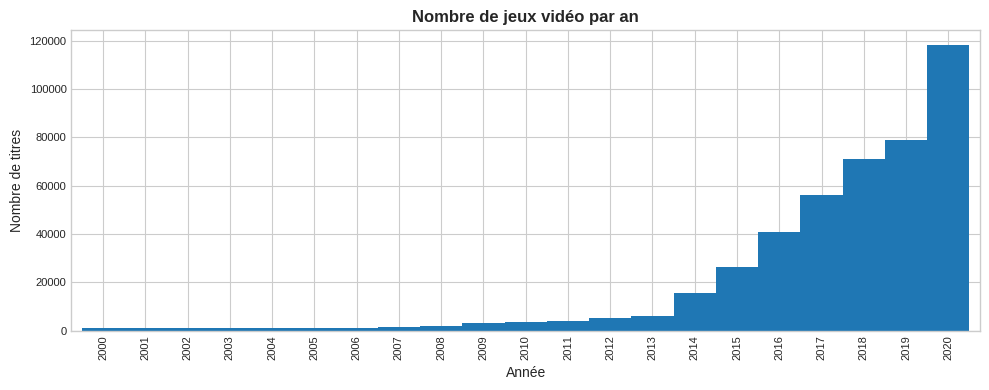

In [130]:
# Compte le nombre de titres par années
release_year_counts = df_allvg['Annee'].value_counts().sort_index()

# Création du graphique compact
plt.figure(figsize=(10, 4))  # plus petit
release_year_counts.plot(kind='bar', width=1.0)  # barres qui se touchent

plt.title('Nombre de jeux vidéo par an', fontsize=12, fontweight='bold')
plt.xlabel('Année', fontsize=10)
plt.ylabel('Nombre de titres', fontsize=10)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()


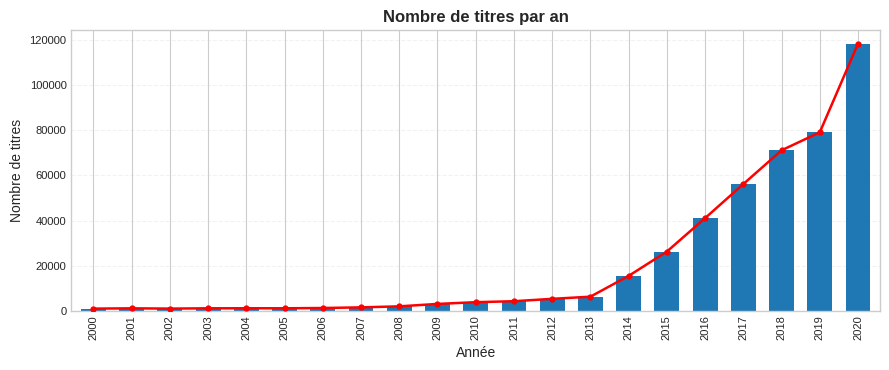

In [131]:
# Compter les titres par année
release_year_counts = (
    df_allvg['Annee'].dropna().astype(int).value_counts().sort_index()
)

# Graphique compact
fig, ax = plt.subplots(figsize=(9, 3.8))

# Barres + réduction de la largeur
release_year_counts.plot(kind='bar', width=0.65, ax=ax)

# Ligne rouge reliant les centres des barres
x = range(len(release_year_counts))
y = release_year_counts.values
ax.plot(x, y, color='red', linewidth=1.8, marker='o', markersize=3.5, zorder=3)

# Habillage léger
ax.set_title('Nombre de titres par an', fontsize=12, fontweight='bold')
ax.set_xlabel('Année', fontsize=10)
ax.set_ylabel('Nombre de titres', fontsize=10)
ax.set_xticklabels(release_year_counts.index, rotation=90, fontsize=8)
ax.tick_params(axis='y', labelsize=8)
ax.grid(axis='y', alpha=0.25, linestyle='--')
fig.tight_layout()
plt.show()


<>:2: SyntaxWarning: invalid escape sequence '\|'
<>:2: SyntaxWarning: invalid escape sequence '\|'
/tmp/ipython-input-2354341752.py:2: SyntaxWarning: invalid escape sequence '\|'
  genre_counts = df_allvg['genres'].str.split('\|\|').explode().value_counts()


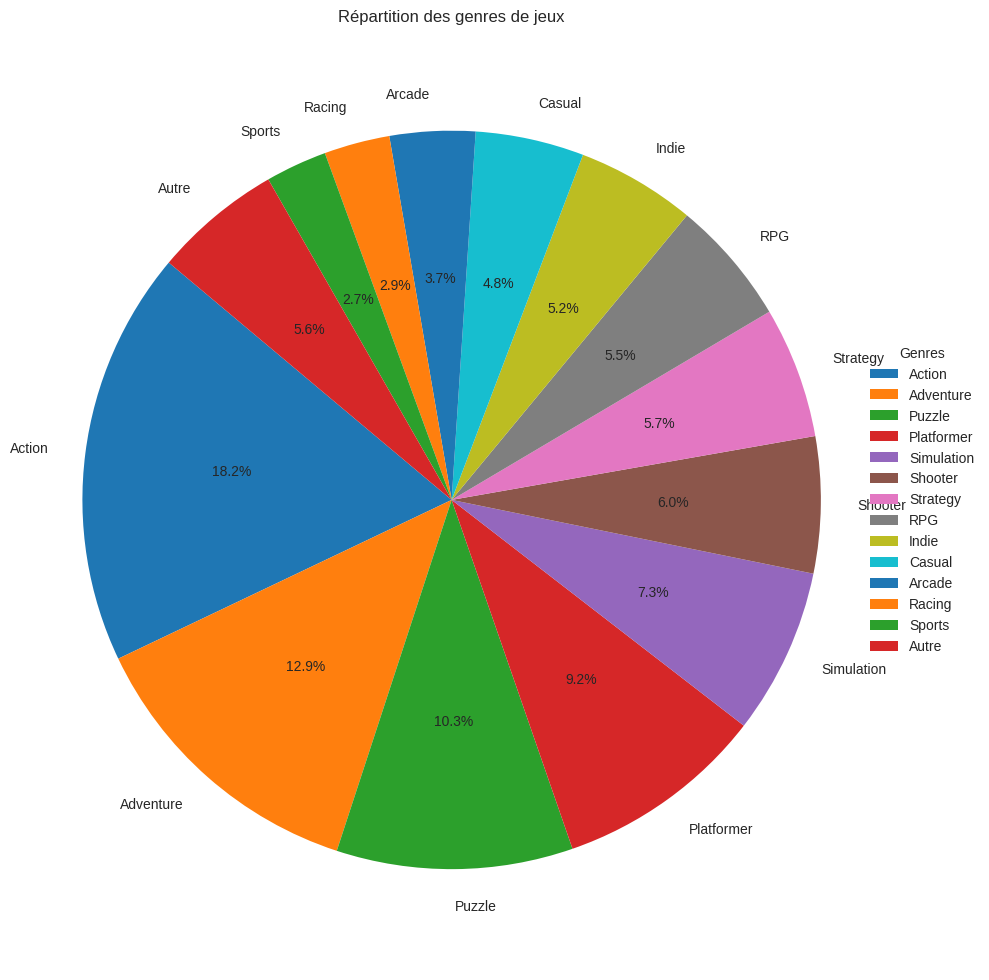

In [132]:
# Compter le nombre de jeux par genre
genre_counts = df_allvg['genres'].str.split('\|\|').explode().value_counts()

# Calculer le pourcentage de chaque genre
genre_percentages = genre_counts / genre_counts.sum()

# Identifier les genres à regrouper dans "Autre" (moins de 2%)
other_genres = genre_percentages[genre_percentages < 0.02].index

# Regrouper les genres moins fréquents
genre_counts_grouped = genre_counts.copy()
genre_counts_grouped['Autre'] = genre_counts_grouped[other_genres].sum()
genre_counts_grouped = genre_counts_grouped.drop(other_genres)

# Créer un graphique en secteurs (camembert)
plt.figure(figsize=(10, 10))
plt.pie(genre_counts_grouped, labels=genre_counts_grouped.index, autopct='%1.1f%%', startangle=140)
plt.title('Répartition des genres de jeux')
plt.axis('equal')  # Assure que le camembert est un cercle
plt.legend(title="Genres", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.tight_layout()
plt.show()

on rajoute un test de correlation sur le score critique du jeu par rapport au genre action/aventure car il semble revenir souvent. on prend dv2024 et on ne prends que els critiques depuis 2020 pour etre sur les "gouts" récents

Corrélation entre score critique et segment Action/Aventure : 0.219


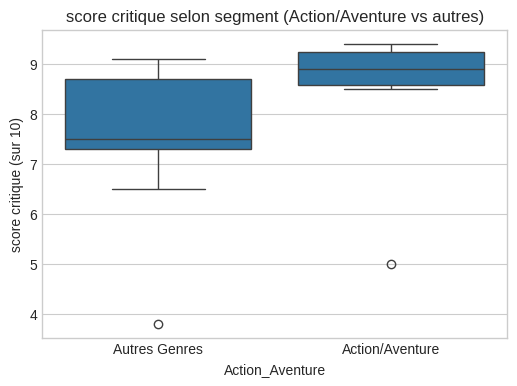

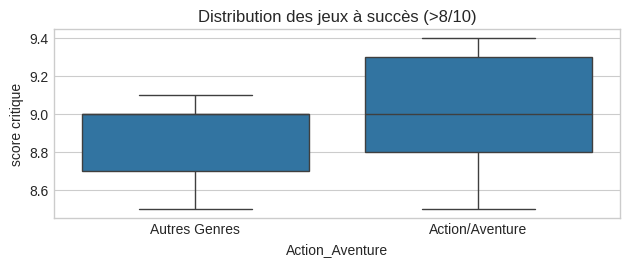

In [133]:
# Utiliser le DataFrame df_salesGlobal déjà chargé
df = df2024[df2024['Year'] > 2019].copy()

# Nettoyage basique : suppression des lignes sans ventes ou genre
df = df.dropna(subset=["Genre", "critic_score"])

# S'assurer que la colonne Genre est de type string pour éviter les erreurs
df['Genre'] = df['Genre'].astype(str)

# Créer une variable binaire : 1 si Action ou Adventure, sinon 0
# Utiliser .str.contains() pour vérifier la présence des genres
df["Action_Aventure"] = df["Genre"].apply(lambda g: 1 if "Action" in g or "Adventure" in g else 0)

# Calcul de la corrélation de Pearson
corr = df["Action_Aventure"].corr(df["critic_score"])
print(f"Corrélation entre score critique et segment Action/Aventure : {corr:.3f}")

# Visualisation simple
plt.figure(figsize=(6,4))
sns.boxplot(x="Action_Aventure", y="critic_score", data=df)
plt.xticks([0,1], ["Autres Genres", "Action/Aventure"])
plt.title("score critique selon segment (Action/Aventure vs autres)")
plt.ylabel("score critique (sur 10)")
plt.show()

plt.subplot(2, 1, 2)
df_top = df[df["critic_score"] > 8.0]
sns.boxplot(x="Action_Aventure", y="critic_score", data=df_top)
plt.xticks([0, 1], ["Autres Genres", "Action/Aventure"])
plt.title("Distribution des jeux à succès (>8/10)")
plt.ylabel("score critique")

plt.tight_layout()
plt.show()

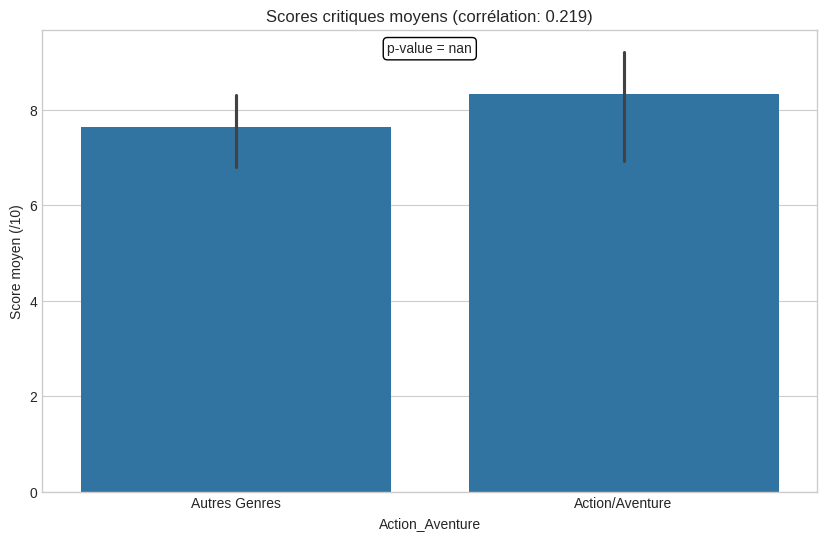

In [134]:
plt.figure(figsize=(10, 6))

# Distribution avec intervalle de confiance
sns.barplot(x="Action_Aventure", y="critic_score", data=df, errorbar='ci')
plt.xticks([0, 1], ["Autres Genres", "Action/Aventure"])
plt.title(f"Scores critiques moyens (corrélation: {corr:.3f})")
plt.ylabel("Score moyen (/10)")
plt.annotate(f"p-value = {p_value:.4f}",
             xy=(0.5, 0.95), xycoords='axes fraction',
             ha='center', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white"))

plt.show()

<>:5: SyntaxWarning: invalid escape sequence '\|'
<>:5: SyntaxWarning: invalid escape sequence '\|'
/tmp/ipython-input-3538881189.py:5: SyntaxWarning: invalid escape sequence '\|'
  platform_counts_2020 = df_allvg_2020['platforms'].str.split('\|\|').explode().value_counts()


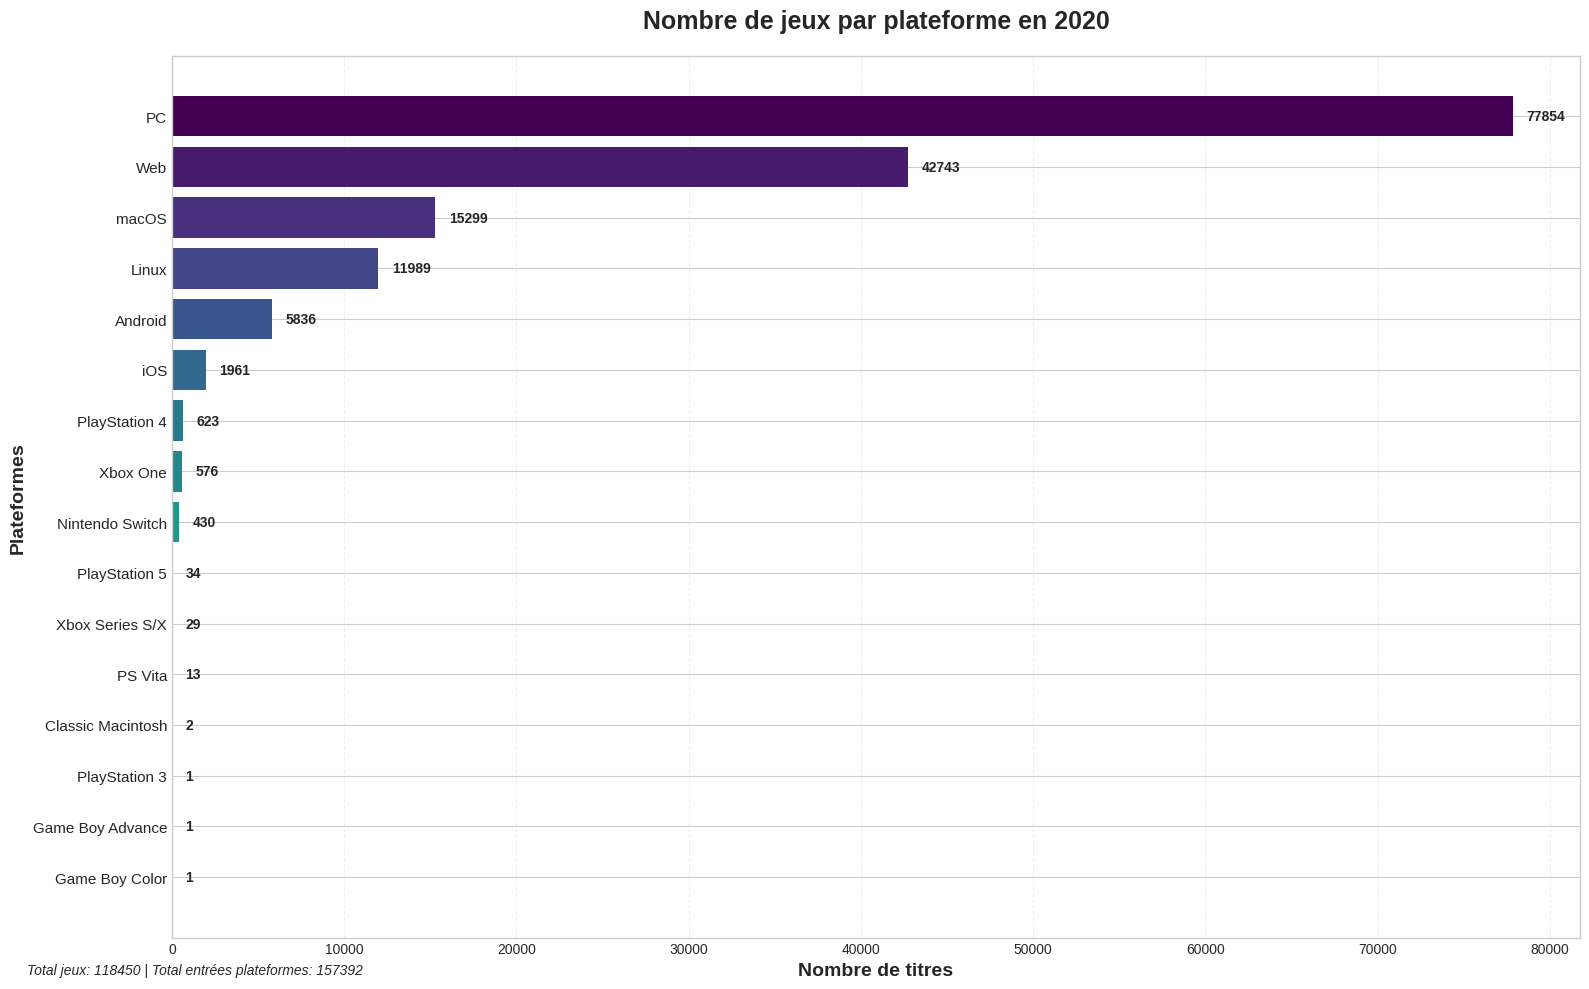

 TOP 10 des plateformes avec le plus de jeux en 2020:
--------------------------------------------------
 1. PC                   : 77854 jeux
 2. Web                  : 42743 jeux
 3. macOS                : 15299 jeux
 4. Linux                : 11989 jeux
 5. Android              : 5836 jeux
 6. iOS                  : 1961 jeux
 7. PlayStation 4        :  623 jeux
 8. Xbox One             :  576 jeux
 9. Nintendo Switch      :  430 jeux
10. PlayStation 5        :   34 jeux
--------------------------------------------------
 Total: 16 plateformes différentes


In [135]:
# Filtre pour les jeux sortis en 2020
df_allvg_2020 = df_allvg[df_allvg['Annee'] == 2020].copy()

# Diviser la colonne « platforms » et compter le nombre d'occurrences de chaque plateforme
platform_counts_2020 = df_allvg_2020['platforms'].str.split('\|\|').explode().value_counts()

# Créer le graphique avec des améliorations visuelles
plt.figure(figsize=(16, 10))

# Utiliser des couleurs dégradées
colors = plt.cm.viridis(np.linspace(0, 1, len(platform_counts_2020)))

# Créer le graphique en barres horizontales pour une meilleure lisibilité
bars = plt.barh(range(len(platform_counts_2020)), platform_counts_2020.values, color=colors)

# Personnaliser l'apparence
plt.title('Nombre de jeux par plateforme en 2020', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Nombre de titres', fontsize=14, fontweight='bold')
plt.ylabel('Plateformes', fontsize=14, fontweight='bold')

# Inverser l'ordre pour avoir les valeurs les plus élevées en haut
plt.gca().invert_yaxis()

# Utiliser les noms des plateformes comme labels
plt.yticks(range(len(platform_counts_2020)), platform_counts_2020.index, fontsize=11)

# Ajouter les valeurs sur chaque barre
for i, (bar, value) in enumerate(zip(bars, platform_counts_2020.values)):
    plt.text(value + max(platform_counts_2020.values) * 0.01, i, str(value),
             va='center', ha='left', fontweight='bold', fontsize=10)

# Ajouter une grille pour faciliter la lecture
plt.grid(axis='x', alpha=0.3, linestyle='--')

# Améliorer la mise en page
plt.tight_layout()

# Ajouter des statistiques
total_games = len(df_allvg_2020)
total_platform_entries = platform_counts_2020.sum()
plt.figtext(0.02, 0.02, f'Total jeux: {total_games} | Total entrées plateformes: {total_platform_entries}',
            fontsize=10, style='italic')

plt.show()

# Afficher aussi les top 10 pour plus de clarté
print(" TOP 10 des plateformes avec le plus de jeux en 2020:")
print("-" * 50)
for i, (platform, count) in enumerate(platform_counts_2020.head(10).items(), 1):
    print(f"{i:2d}. {platform:<20} : {count:>4} jeux")
print("-" * 50)
print(f" Total: {len(platform_counts_2020)} plateformes différentes")

<>:5: SyntaxWarning: invalid escape sequence '\|'
<>:5: SyntaxWarning: invalid escape sequence '\|'
/tmp/ipython-input-2974421697.py:5: SyntaxWarning: invalid escape sequence '\|'
  df_allvg_2020['nb_platforms'] = df_allvg_2020['platforms'].str.count('\|\|') + 1


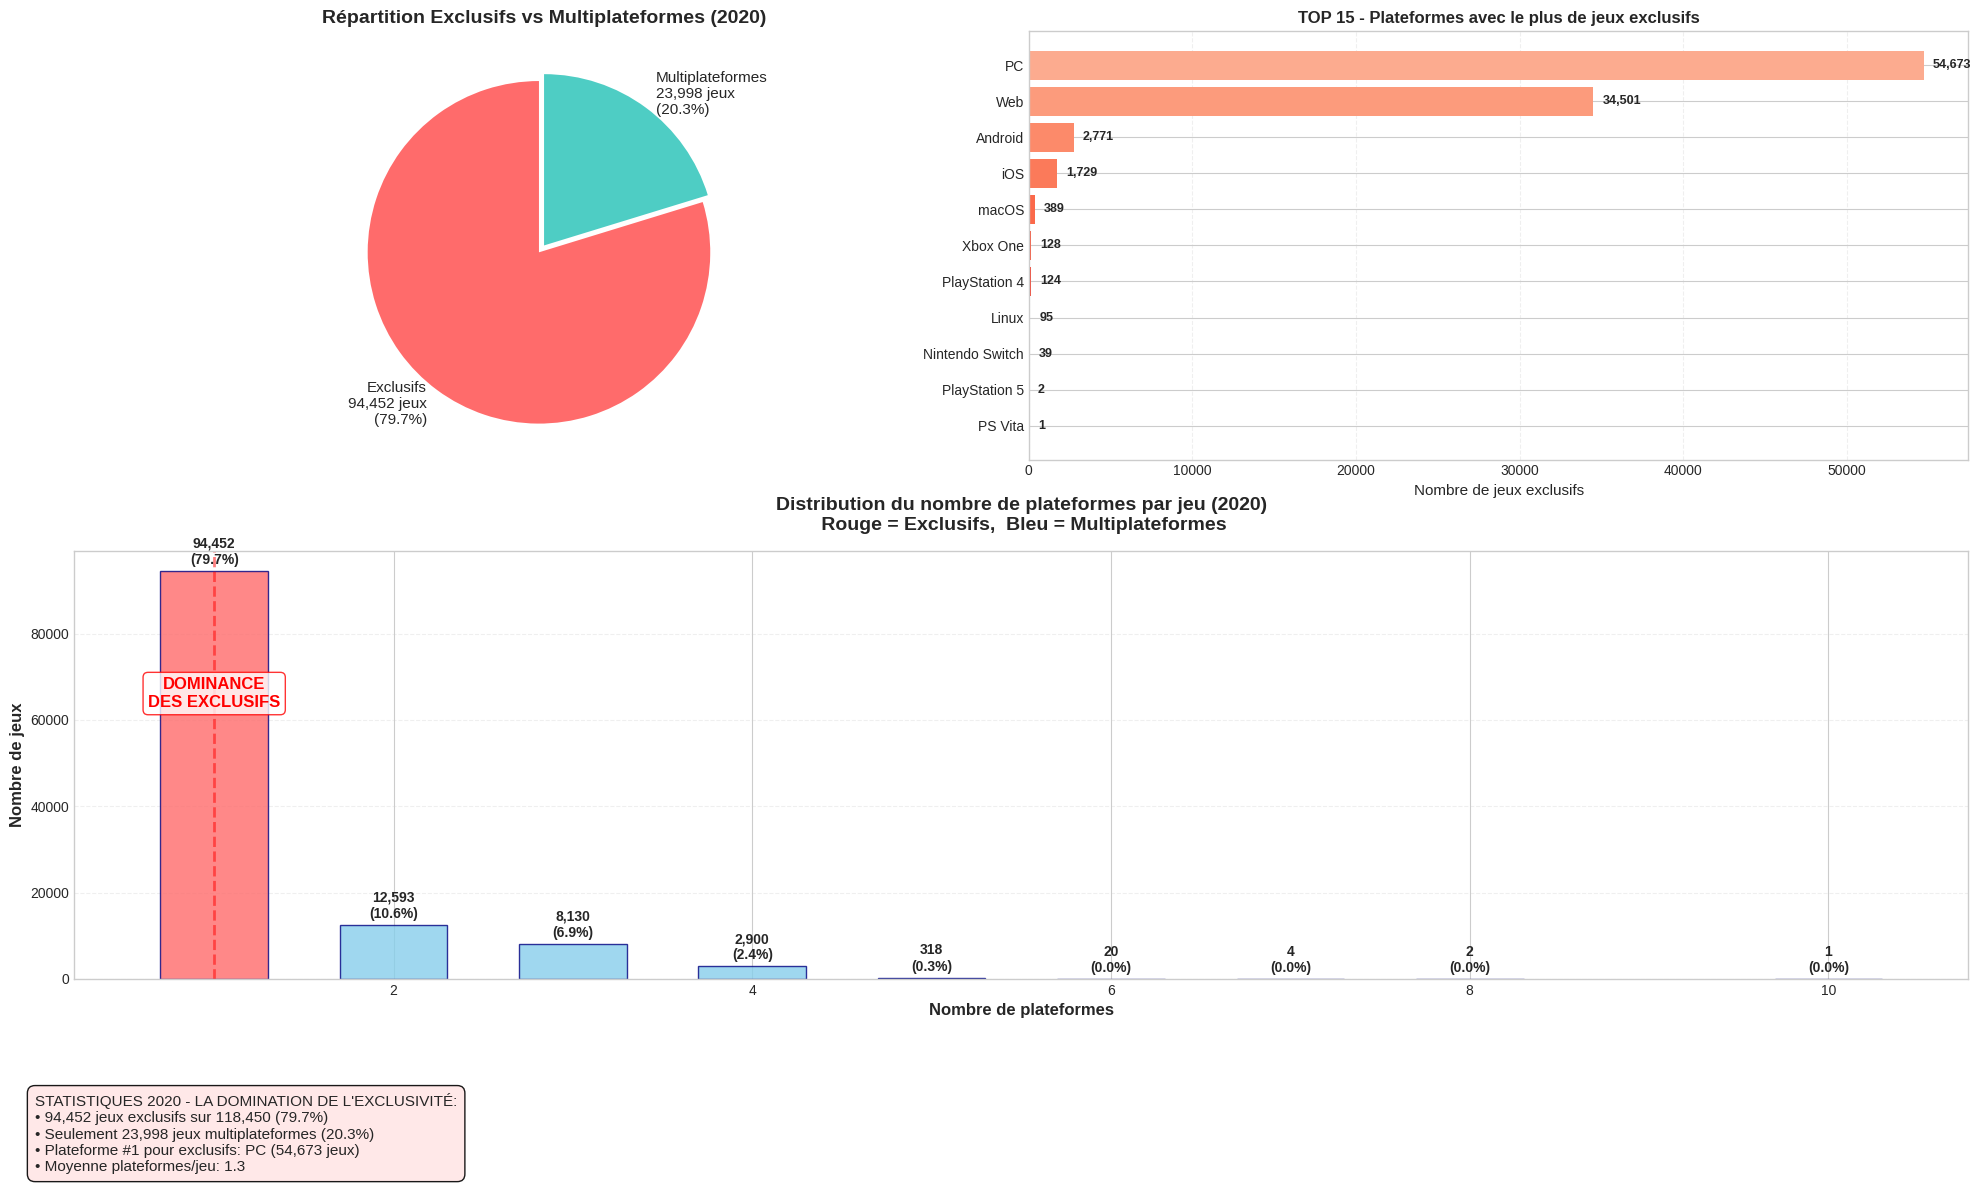

🎮 ANALYSE: LA DOMINATION DE L'EXCLUSIVITÉ EN 2020
📈 CONSTAT MAJEUR: 79.7% des jeux sont EXCLUSIFS !
   • 94,452 jeux exclusifs vs 23,998 multiplateformes
   • Ratio: 3.9 exclusif pour 1 multiplateforme

🏆 TOP 10 PLATEFORMES AVEC LE PLUS D'EXCLUSIFS:
--------------------------------------------------
 1. PC                        : 54,673 exclusifs (57.9% du total exclusifs)
 2. Web                       : 34,501 exclusifs (36.5% du total exclusifs)
 3. Android                   :  2,771 exclusifs (2.9% du total exclusifs)
 4. iOS                       :  1,729 exclusifs (1.8% du total exclusifs)
 5. macOS                     :    389 exclusifs (0.4% du total exclusifs)
 6. Xbox One                  :    128 exclusifs (0.1% du total exclusifs)
 7. PlayStation 4             :    124 exclusifs (0.1% du total exclusifs)
 8. Linux                     :     95 exclusifs (0.1% du total exclusifs)
 9. Nintendo Switch           :     39 exclusifs (0.0% du total exclusifs)
10. PlayStation 5     

In [136]:

# Filtre pour les jeux sortis en 2020
df_allvg_2020 = df_allvg[df_allvg['Annee'] == 2020].copy()

# Compter le nombre de plateformes par jeu
df_allvg_2020['nb_platforms'] = df_allvg_2020['platforms'].str.count('\|\|') + 1

# Identifier les jeux exclusifs (1 seule plateforme)
df_exclusives = df_allvg_2020[df_allvg_2020['nb_platforms'] == 1].copy()

# Compter les exclusifs par plateforme
exclusive_counts = df_exclusives['platforms'].value_counts()

# Créer une figure avec trois sous-graphiques
fig = plt.figure(figsize=(20, 12))

# GRAPHIQUE 1: Camembert Exclusif vs Multiplateforme (en haut à gauche)
ax1 = plt.subplot(2, 2, 1)
total_games = len(df_allvg_2020)
exclusive_games = len(df_exclusives)
multiplatform_games = total_games - exclusive_games

sizes = [exclusive_games, multiplatform_games]
labels = [f'Exclusifs\n{exclusive_games:,} jeux\n({exclusive_games/total_games*100:.1f}%)',
          f'Multiplateformes\n{multiplatform_games:,} jeux\n({multiplatform_games/total_games*100:.1f}%)']
colors = ['#ff6b6b', '#4ecdc4']
explode = (0.05, 0)

wedges, texts, autotexts = ax1.pie(sizes, labels=labels, autopct='', startangle=90,
                                   colors=colors, explode=explode, textprops={'fontsize': 11})
ax1.set_title('Répartition Exclusifs vs Multiplateformes (2020)', fontsize=14, fontweight='bold')

# GRAPHIQUE 2: TOP 15 des plateformes avec le plus d'exclusifs (en haut à droite)
ax2 = plt.subplot(2, 2, 2)
top_15_exclusives = exclusive_counts.head(15)

bars = ax2.barh(range(len(top_15_exclusives)), top_15_exclusives.values,
                color=plt.cm.Reds(np.linspace(0.3, 0.8, len(top_15_exclusives))))
ax2.invert_yaxis()
ax2.set_yticks(range(len(top_15_exclusives)))
ax2.set_yticklabels(top_15_exclusives.index, fontsize=10)
ax2.set_title('TOP 15 - Plateformes avec le plus de jeux exclusifs', fontsize=12, fontweight='bold')
ax2.set_xlabel('Nombre de jeux exclusifs', fontsize=11)

for i, (bar, value) in enumerate(zip(bars, top_15_exclusives.values)):
    ax2.text(value + max(top_15_exclusives.values) * 0.01, i, f'{value:,}',
             va='center', ha='left', fontweight='bold', fontsize=9)
ax2.grid(axis='x', alpha=0.3, linestyle='--')

# GRAPHIQUE 3: Distribution du nombre de plateformes (en bas, sur toute la largeur)
ax3 = plt.subplot(2, 1, 2)
platform_counts = df_allvg_2020['nb_platforms'].value_counts().sort_index()

bars = ax3.bar(platform_counts.index, platform_counts.values,
               color=['#ff6b6b' if x == 1 else '#87ceeb' for x in platform_counts.index],
               edgecolor='navy', alpha=0.8, width=0.6)

ax3.set_title('Distribution du nombre de plateformes par jeu (2020)\n Rouge = Exclusifs,  Bleu = Multiplateformes',
              fontsize=14, fontweight='bold', pad=15)
ax3.set_xlabel('Nombre de plateformes', fontsize=12, fontweight='bold')
ax3.set_ylabel('Nombre de jeux', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3, linestyle='--')

for i, (nb_plat, count) in enumerate(platform_counts.items()):
    percentage = (count / total_games) * 100
    ax3.text(nb_plat, count + max(platform_counts.values) * 0.01,
             f'{count:,}\n({percentage:.1f}%)', ha='center', va='bottom',
             fontweight='bold', fontsize=10)

ax3.axvline(x=1, color='red', linestyle='--', alpha=0.5, linewidth=2)
ax3.text(1, max(platform_counts.values) * 0.7, 'DOMINANCE\nDES EXCLUSIFS',
         ha='center', va='center', fontweight='bold', fontsize=12, color='red',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="red", alpha=0.8))

plt.tight_layout()

# AJOUT DE SUBLOTS_ADJUST POUR FAIRE DE LA PLACE EN BAS

plt.subplots_adjust(bottom=0.18)


stats_text = f"""STATISTIQUES 2020 - LA DOMINATION DE L'EXCLUSIVITÉ:
• {exclusive_games:,} jeux exclusifs sur {total_games:,} ({exclusive_games/total_games*100:.1f}%)
• Seulement {multiplatform_games:,} jeux multiplateformes ({multiplatform_games/total_games*100:.1f}%)
• Plateforme #1 pour exclusifs: {exclusive_counts.index[0]} ({exclusive_counts.iloc[0]:,} jeux)
• Moyenne plateformes/jeu: {df_allvg_2020['nb_platforms'].mean():.1f}"""

plt.figtext(0.02, 0.02, stats_text, fontsize=11,
           bbox=dict(boxstyle="round,pad=0.5", facecolor="#ffe6e6", alpha=0.9))

plt.show()


# Analyse textuelle complète
print("🎮 ANALYSE: LA DOMINATION DE L'EXCLUSIVITÉ EN 2020")
print("="*60)
print(f"📈 CONSTAT MAJEUR: {exclusive_games/total_games*100:.1f}% des jeux sont EXCLUSIFS !")
print(f"   • {exclusive_games:,} jeux exclusifs vs {multiplatform_games:,} multiplateformes")
print(f"   • Ratio: {exclusive_games/multiplatform_games:.1f} exclusif pour 1 multiplateforme")

print(f"\n🏆 TOP 10 PLATEFORMES AVEC LE PLUS D'EXCLUSIFS:")
print("-"*50)
for i, (platform, count) in enumerate(exclusive_counts.head(10).items(), 1):
    percentage = (count / exclusive_games) * 100
    print(f"{i:2d}. {platform:<25} : {count:>6,} exclusifs ({percentage:.1f}% du total exclusifs)")

print(f"\n📊 RÉPARTITION PAR NOMBRE DE PLATEFORMES:")
print("-"*50)
for nb_plat, count in platform_counts.items():
    percentage = (count / total_games) * 100
    status = "🔴 EXCLUSIFS" if nb_plat == 1 else "🔵 Multiplateformes"
    print(f"{nb_plat:2.0f} plateforme{'s' if nb_plat > 1 else ' '}: {count:>6,} jeux ({percentage:>5.1f}%) {status}")

print(f"\n💡 CONCLUSION:")
print(f"Contrairement aux idées reçues, l'exclusivité DOMINE encore en 2020.")
print(f"Les stratégies multiplateformes restent minoritaires ({multiplatform_games/total_games*100:.1f}%).")


<>:5: SyntaxWarning: invalid escape sequence '\|'
<>:40: SyntaxWarning: invalid escape sequence '\|'
<>:5: SyntaxWarning: invalid escape sequence '\|'
<>:40: SyntaxWarning: invalid escape sequence '\|'
/tmp/ipython-input-2148932684.py:5: SyntaxWarning: invalid escape sequence '\|'
  df_allvg_2020['nb_platforms'] = df_allvg_2020['platforms'].str.count('\|\|') + 1
/tmp/ipython-input-2148932684.py:40: SyntaxWarning: invalid escape sequence '\|'
  all_platforms_top20 = df_top20['platforms'].str.split('\|\|').explode()


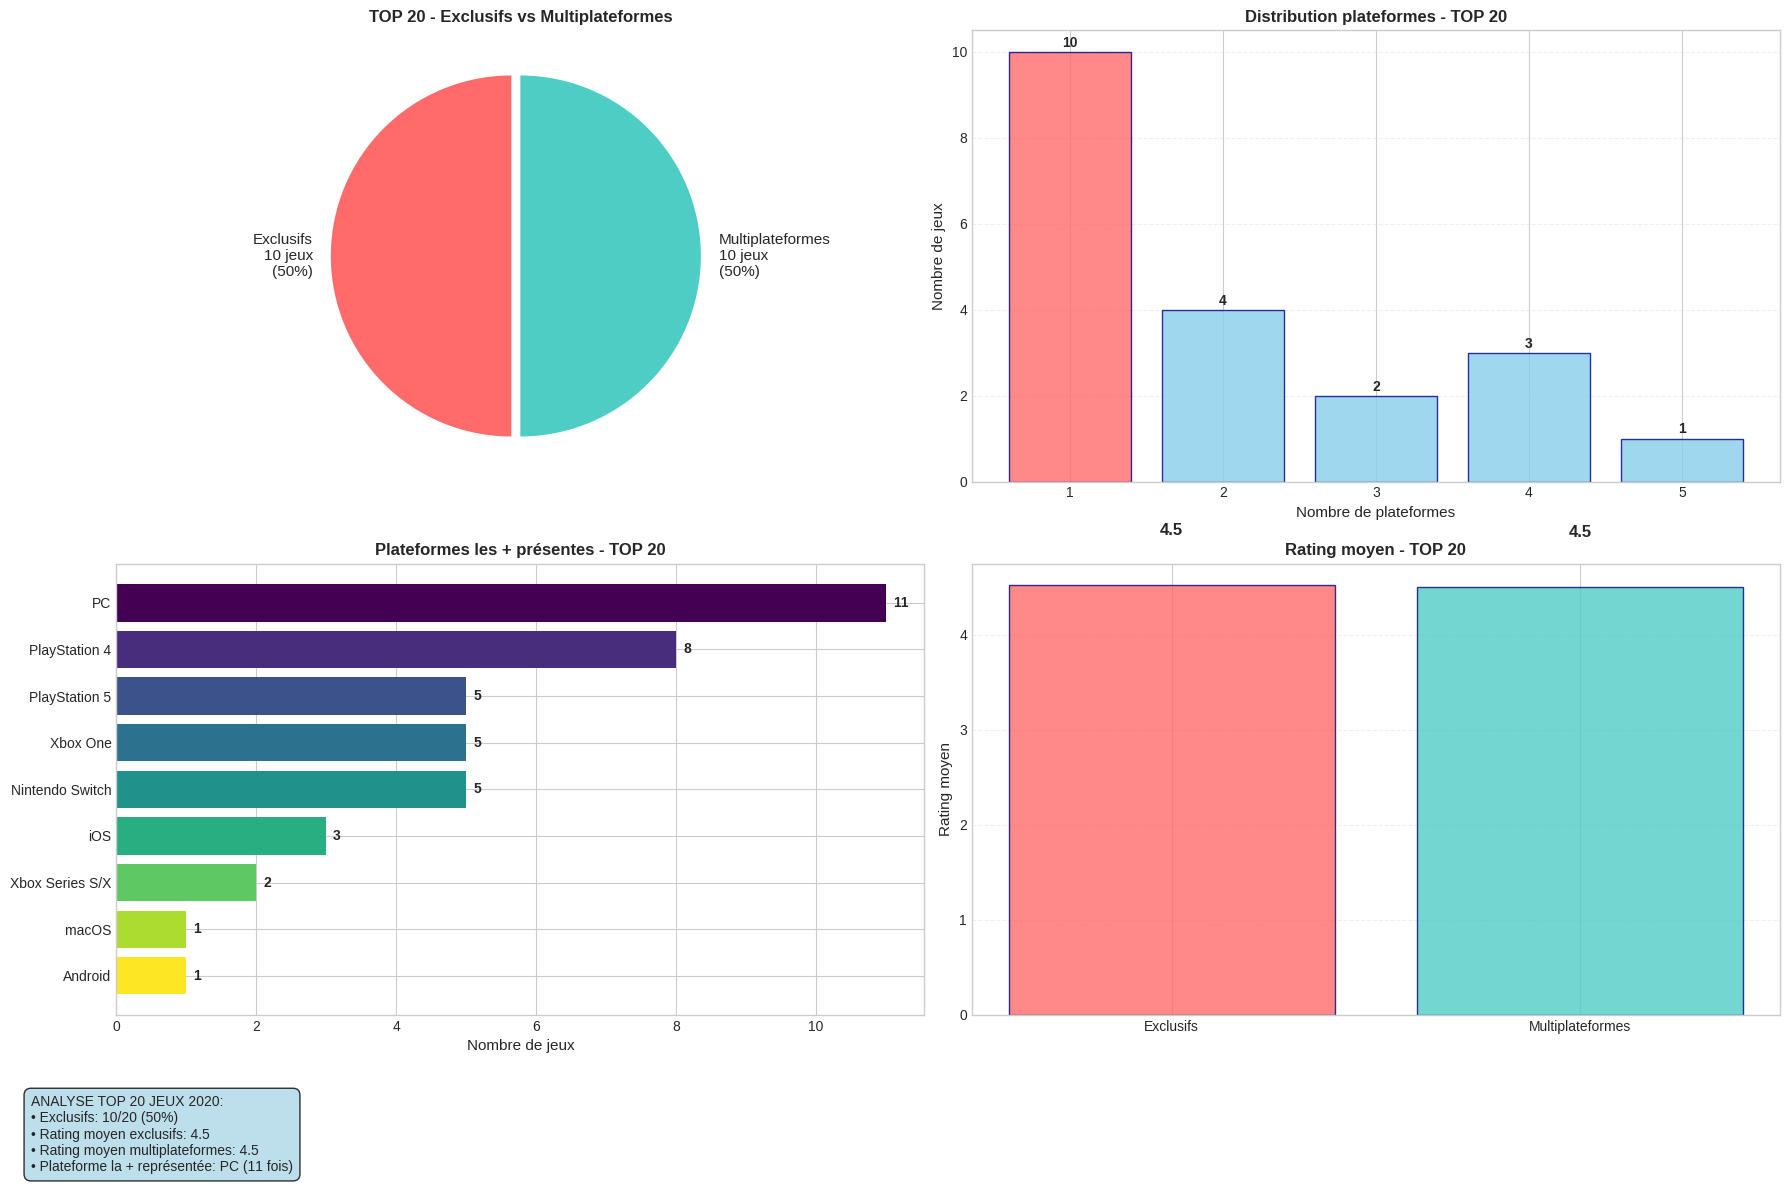


🔵 JEUX MULTIPLATEFORMES DU TOP 20:
------------------------------------------------------------
• Yakuza: Like a Dragon (Rating: 4.73)
  └─ 5 plateformes: PlayStation 5, Xbox Series S/X, Xbox One, PC, PlayStation 4

• The Henry Stickmin Collection (Rating: 4.67)
  └─ 2 plateformes: iOS, PC

• Hades (Rating: 4.51)
  └─ 2 plateformes: PC, Nintendo Switch

• Ministry of Broadcast (Rating: 4.5)
  └─ 4 plateformes: iOS, PC, Nintendo Switch, macOS

• Arknights (Rating: 4.5)
  └─ 3 plateformes: PC, iOS, Android

• Ghost of Tsushima (Rating: 4.47)
  └─ 2 plateformes: PlayStation 5, PlayStation 4

• Ori and the Will of the Wisps (Rating: 4.44)
  └─ 4 plateformes: PC, Nintendo Switch, Xbox Series S/X, Xbox One

• Tony Hawk's Pro Skater 1 + 2 (Rating: 4.4)
  └─ 3 plateformes: Xbox One, PlayStation 4, PC

• The Last of Us Part II (Rating: 4.39)
  └─ 2 plateformes: PlayStation 4, PlayStation 5

• DOOM Eternal (Rating: 4.38)
  └─ 4 plateformes: PC, Nintendo Switch, PlayStation 4, Xbox One


 COMPAR

In [137]:

# Filter for games released in 2020
df_allvg_2020 = df_allvg[df_allvg['Annee'] == 2020].copy()

# Compter le nombre de plateformes par jeu
df_allvg_2020['nb_platforms'] = df_allvg_2020['platforms'].str.count('\|\|') + 1

# Trier par rating et prendre les 20 premiers
df_top20 = df_allvg_2020[df_allvg_2020['rating'] > 0].nlargest(20, 'rating').copy()


# Créer une figure avec plusieurs analyses
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# GRAPHIQUE 1: Répartition Exclusifs vs Multiplateformes dans le TOP 20
exclusifs_top20 = len(df_top20[df_top20['nb_platforms'] == 1])
multi_top20 = 20 - exclusifs_top20
sizes = [exclusifs_top20, multi_top20]
labels = [f'Exclusifs\n{exclusifs_top20} jeux\n({exclusifs_top20/20*100:.0f}%)',
          f'Multiplateformes\n{multi_top20} jeux\n({multi_top20/20*100:.0f}%)']
colors = ['#ff6b6b', '#4ecdc4']
explode = (0.05, 0)
ax1.pie(sizes, labels=labels, autopct='', startangle=90, colors=colors, explode=explode, textprops={'fontsize': 11})
ax1.set_title('TOP 20 - Exclusifs vs Multiplateformes', fontsize=12, fontweight='bold')

# GRAPHIQUE 2: Distribution du nombre de plateformes dans le TOP 20
platform_dist_top20 = df_top20['nb_platforms'].value_counts().sort_index()
bars = ax2.bar(platform_dist_top20.index, platform_dist_top20.values,
               color=['#ff6b6b' if x == 1 else '#87ceeb' for x in platform_dist_top20.index],
               edgecolor='navy', alpha=0.8)
ax2.set_title('Distribution plateformes - TOP 20', fontsize=12, fontweight='bold')
ax2.set_xlabel('Nombre de plateformes', fontsize=11)
ax2.set_ylabel('Nombre de jeux', fontsize=11)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# GRAPHIQUE 3: Plateformes les plus présentes dans le TOP 20
all_platforms_top20 = df_top20['platforms'].str.split('\|\|').explode()
platform_counts_top20 = all_platforms_top20.value_counts()
top_platforms = platform_counts_top20.head(10)
bars = ax3.barh(range(len(top_platforms)), top_platforms.values,
                color=plt.cm.viridis(np.linspace(0, 1, len(top_platforms))))
ax3.invert_yaxis()
ax3.set_yticks(range(len(top_platforms)))
ax3.set_yticklabels(top_platforms.index, fontsize=10)
ax3.set_title('Plateformes les + présentes - TOP 20', fontsize=12, fontweight='bold')
ax3.set_xlabel('Nombre de jeux', fontsize=11)
for i, (bar, value) in enumerate(zip(bars, top_platforms.values)):
    ax3.text(value + 0.1, i, str(value), va='center', ha='left', fontweight='bold')

# GRAPHIQUE 4: Comparaison rating moyens Exclusifs vs Multiplateformes
exclusifs_rating = df_top20[df_top20['nb_platforms'] == 1]['rating'].mean()
multi_rating = df_top20[df_top20['nb_platforms'] > 1]['rating'].mean()
categories = ['Exclusifs', 'Multiplateformes']
avg_rating = [exclusifs_rating, multi_rating]
colors_comp = ['#ff6b6b', '#4ecdc4']
bars = ax4.bar(categories, avg_rating, color=colors_comp, alpha=0.8, edgecolor='navy')
ax4.set_title('Rating moyen - TOP 20', fontsize=12, fontweight='bold')
ax4.set_ylabel('Rating moyen', fontsize=11)
ax4.grid(axis='y', alpha=0.3, linestyle='--')
for bar, value in zip(bars, avg_rating):
    ax4.text(bar.get_x() + bar.get_width()/2., value + 0.5,
             f'{value:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()


# On ajuste la marge inférieure pour laisser 15% de la hauteur pour le texte de statistiques.
plt.subplots_adjust(bottom=0.15)

# Statistiques détaillées
stats_text = f"""ANALYSE TOP 20 JEUX 2020:
• Exclusifs: {exclusifs_top20}/20 ({exclusifs_top20/20*100:.0f}%)
• Rating moyen exclusifs: {exclusifs_rating:.1f}
• Rating moyen multiplateformes: {multi_rating:.1f}
• Plateforme la + représentée: {platform_counts_top20.index[0]} ({platform_counts_top20.iloc[0]} fois)"""

plt.figtext(0.02, 0.02, stats_text, fontsize=10,
           bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))

plt.show()

# Analyse détaillée des jeux multiplateformes du TOP 20
print(f"\n🔵 JEUX MULTIPLATEFORMES DU TOP 20:")
print("-"*60)
multi_games = df_top20[df_top20['nb_platforms'] > 1]
for _, game in multi_games.iterrows():
    platforms_list = game['platforms'].replace('||', ', ')
    print(f"• {game['name']} (Rating: {game['rating']})")
    print(f"  └─ {int(game['nb_platforms'])} plateformes: {platforms_list}")
    print()

# Comparaison avec le dataset complet
print(f"\n COMPARAISON TOP 20 vs ENSEMBLE 2020:")
print("-"*50)
total_exclusifs_pct = len(df_allvg_2020[df_allvg_2020['nb_platforms'] == 1]) / len(df_allvg_2020) * 100
top20_exclusifs_pct = exclusifs_top20 / 20 * 100

print(f"Exclusifs dans TOUT 2020: {total_exclusifs_pct:.1f}%")
print(f"Exclusifs dans TOP 20:    {top20_exclusifs_pct:.0f}%")
print(f"Différence: {abs(total_exclusifs_pct - top20_exclusifs_pct):+.1f} points")

if top20_exclusifs_pct > total_exclusifs_pct:
    print("→ Les meilleurs jeux sont PLUS souvent exclusifs")
elif top20_exclusifs_pct < total_exclusifs_pct:
    print("→ Les meilleurs jeux sont MOINS souvent exclusifs")
else:
    print("→ Même tendance entre TOP 20 et ensemble")


on va generer des graphiques plus simple a partir de ce que l'on a deja sorti

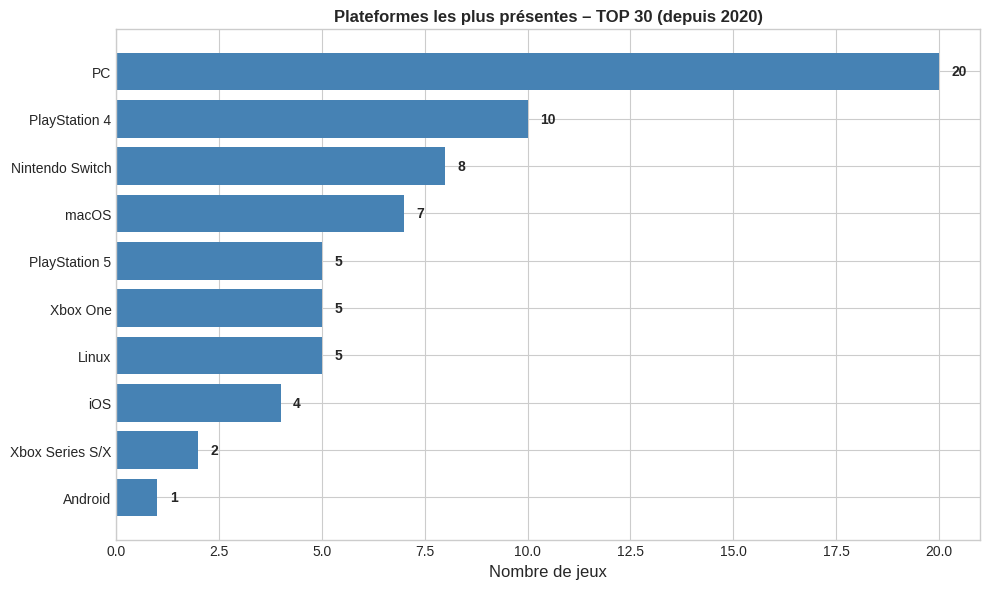

In [138]:
# filtre des jeux créé apres 2020
df_allvg_ap2020 = df_allvg[df_allvg['Annee'] >= 2020].copy()

# Compter le nombre de plateformes par jeu
df_allvg_ap2020['nb_platforms'] = df_allvg_ap2020['platforms'].str.count(r'\|\|') + 1

# Trier par rating et prendre les 20 premiers
df_top30 = df_allvg_ap2020[df_allvg_ap2020['rating'] > 0].nlargest(30, 'rating').copy()

all_platforms_top30 = df_top30['platforms'].str.split(r'\|\|').explode()
platform_counts_top30 = all_platforms_top30.value_counts()
top_platforms = platform_counts_top30.head(10)




plt.figure(figsize=(10, 6))  # plus large
bars = plt.barh(platform_counts_top30.index, platform_counts_top30.values, color="steelblue")

plt.gca().invert_yaxis()
plt.title("Plateformes les plus présentes – TOP 30 (depuis 2020)", fontsize=12, fontweight='bold')
plt.xlabel("Nombre de jeux", fontsize=12)

# Labels lisibles
plt.yticks(fontsize=10)

# Ajouter les valeurs à droite
for bar, val in zip(bars, platform_counts_top30.values):
    plt.text(val + 0.3, bar.get_y() + bar.get_height()/2, str(val),
             va='center', ha='left', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

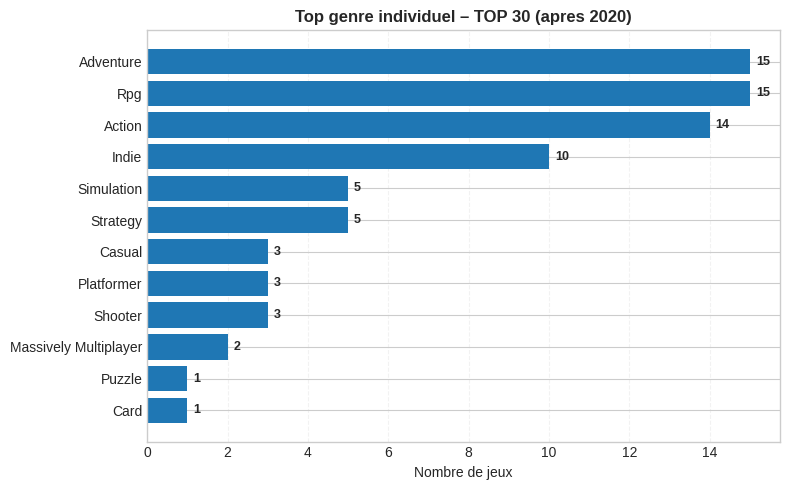

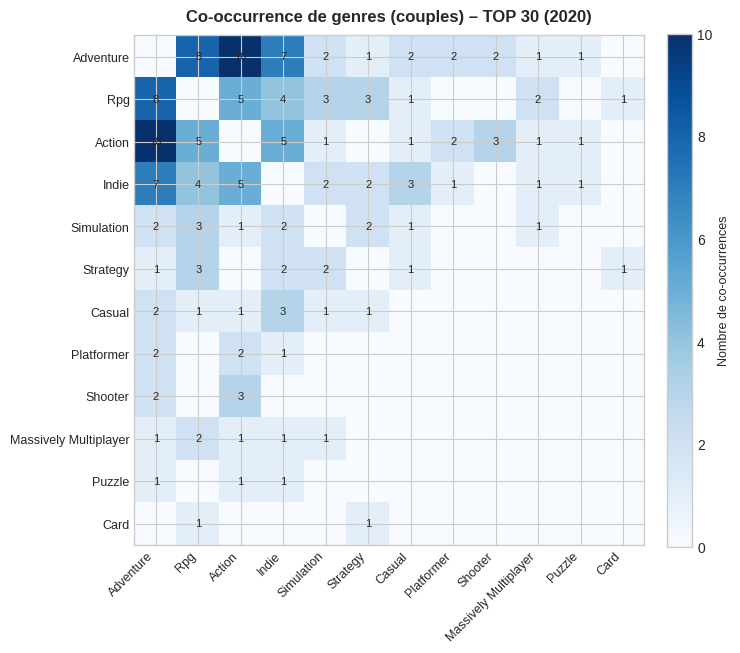

In [139]:
import itertools


# --- 1) Extraction des genres individuels ---
# Séparation, nettoyage, mise en forme cohérente (title-case)
genres_exploded = (
    df_top30['genres']
    .dropna()
    .astype(str)
    .str.split(r'\|\|')
    .explode()
    .str.strip()
)

# Normalisation légère
genres_exploded = genres_exploded.str.replace(r'\s+', ' ', regex=True).str.title()

# Comptage des genres (top N)
N = 12
genre_counts = genres_exploded.value_counts().head(N)

# --- Graphe A : Top genres (barres horizontales) ---
plt.figure(figsize=(8, 5))
bars = plt.barh(genre_counts.index, genre_counts.values)
plt.gca().invert_yaxis()
plt.title("Top genre individuel – TOP 30 (apres 2020)", fontsize=12, fontweight='bold')
plt.xlabel("Nombre de jeux", fontsize=10)
plt.grid(axis='x', alpha=0.25, linestyle='--')
for bar, v in zip(bars, genre_counts.values):
    plt.text(v + 0.15, bar.get_y() + bar.get_height()/2, str(v),
             va='center', ha='left', fontsize=9, fontweight='bold')
plt.tight_layout()
plt.show()

# --- 2) Co-occurrences de genres (paires) ---
# Transforme chaque ligne en set de genres (évite doublons dans un même jeu)
rows_genres = (
    df_top30['genres']
    .dropna()
    .astype(str)
    .str.split(r'\|\|')
    .apply(lambda lst: sorted({g.strip().title() for g in lst if g.strip()}))
)

# Compte les paires (combinaisons à 2) sur l'ensemble du TOP 20
pair_counts = {}
for glist in rows_genres:
    for a, b in itertools.combinations(glist, 2):
        key = tuple(sorted((a, b)))
        pair_counts[key] = pair_counts.get(key, 0) + 1

# On limite  aux genres les plus fréquents (mêmes que Graphe A)
top_genres = list(genre_counts.index)

# Matrice de co-occurrence des genres
mat = np.zeros((len(top_genres), len(top_genres)), dtype=int)
idx = {g:i for i, g in enumerate(top_genres)}
for (a, b), c in pair_counts.items():
    if a in idx and b in idx:
        ia, ib = idx[a], idx[b]
        mat[ia, ib] = c
        mat[ib, ia] = c  # symétrique

# --- Graphe B : Heatmap simple des co-occurrences (sans seaborn) ---
fig, ax = plt.subplots(figsize=(7.5, 7))
im = ax.imshow(mat, cmap='Blues', vmin=0)

ax.set_title("Co-occurrence de genres (couples) – TOP 30 (2020)", fontsize=12, fontweight='bold', pad=10)
ax.set_xticks(range(len(top_genres)))
ax.set_yticks(range(len(top_genres)))
ax.set_xticklabels(top_genres, rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(top_genres, fontsize=9)

# Annotation des cellules (petites valeurs → texte lisible)
for i in range(len(top_genres)):
    for j in range(len(top_genres)):
        val = mat[i, j]
        if val > 0:
            ax.text(j, i, str(val), ha='center', va='center', fontsize=8)

# Barre de couleur discrète
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel("Nombre de co-occurrences", rotation=90, fontsize=9)

plt.tight_layout()
plt.show()


Heatmap plus correcte

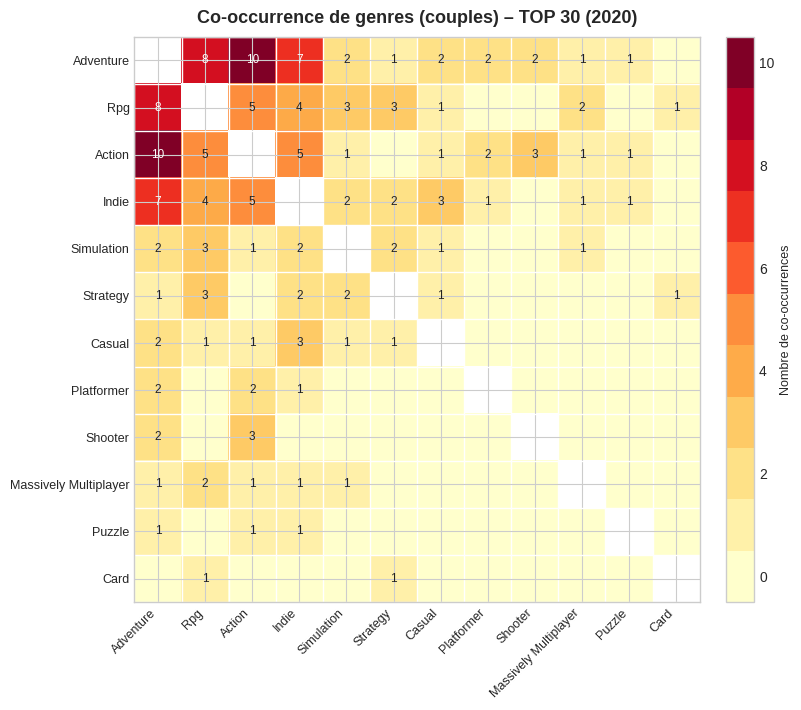

In [140]:
from matplotlib import colors as mcolors

# 1) Normalisation discrète par ENTIER (0,1,2,...,max)
vmax = int(mat.max()) if mat.size else 0
bounds = np.arange(-0.5, vmax + 1.5, 1)  # centres sur les entiers
cmap = plt.cm.YlOrRd.copy()
cmap.set_under('#f0f0f0')  # couleur pour < 0 → utilisable pour 0 masqué
norm = mcolors.BoundaryNorm(bounds, cmap.N)

#  masquer la diagonale pour alléger
mat_plot = mat.copy().astype(float)
np.fill_diagonal(mat_plot, np.nan)  # pas d’auto-cooccurrence

# 2) Heatmap
fig, ax = plt.subplots(figsize=(8.2, 7.2))
im = ax.imshow(mat_plot, cmap=cmap, norm=norm)

ax.set_title("Co-occurrence de genres (couples) – TOP 30 (2020)", fontsize=13, fontweight='bold', pad=10)
ax.set_xticks(range(len(top_genres)))
ax.set_yticks(range(len(top_genres)))
ax.set_xticklabels(top_genres, rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(top_genres, fontsize=9)

# 3) Grille fine pour séparer les cases
ax.set_xticks(np.arange(-0.5, len(top_genres), 1), minor=True)
ax.set_yticks(np.arange(-0.5, len(top_genres), 1), minor=True)
ax.grid(which='minor', color='white', linewidth=1)
ax.tick_params(which='minor', bottom=False, left=False)

# 4) Annotations lisibles (couleur du texte selon l’intensité)
def text_color(val):
    # seuil ~60% de l’échelle pour passer en blanc
    return 'white' if (val >= 0.6 * vmax and vmax > 0) else '#222'

for i in range(len(top_genres)):
    for j in range(len(top_genres)):
        val = mat[i, j]
        if val > 0:
            ax.text(j, i, str(val),
                    ha='center', va='center', fontsize=8.5, color=text_color(val))

# 5) Barre de couleur discrète et ticks entiers
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04,
                    ticks=np.arange(0, vmax + 1, max(1, vmax // 5 if vmax >= 5 else 1)))
cbar.ax.set_ylabel("Nombre de co-occurrences", rotation=90, fontsize=9)

ax.set_aspect('equal')  # cases carrées
plt.tight_layout()
plt.show()


In [141]:
df_salesGlobal.head(45)

,Name,Platform,Genre,Publisher,Constructeur,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Year,critic_score
0,Triple Play 99,PS,Sports,NaN,Sony,0.8424,0.5775,0.0000,0.1050,1.5249,0,NaN
1,Charm Girls Club: My Fashion Show,DS,Simulation,Unknown,Nintendo,0.0784,0.0000,0.0000,0.0102,0.0886,0,NaN
2,Adventure,2600,Adventure,Atari,Atati,1.1858,0.0840,0.0000,0.0101,1.2799,0,NaN
3,Super Puzzle Fighter II,GBA,Puzzle,Capcom,Nintendo,0.0612,0.0194,0.0000,0.0000,0.0806,0,NaN
4,Combat Wings: The Great Battles of WWII,Wii,Simulation,City Interactive,Nintendo,0.0202,0.0000,0.0000,0.0000,0.0202,0,NaN
5,Writing and Speaking Beautiful Japanese DS,DS,Misc,Unknown,Nintendo,0.0000,0.0000,0.0200,0.0000,0.0200,0,NaN
6,Payout Poker & Casino,PSP,Misc,Unknown,Sony,0.0206,0.0000,0.0000,0.0000,0.0206,0,NaN
7,Combat Elite: WWII Paratroopers,PS2,Shooter,Unknown,Sony,0.0306,0.0202,0.0000,0.0099,0.0607,0,NaN
8,Agarest Senki: Re-appearance,PS3,Role-Playing,Idea Factory,Sony,0.0000,0.0000,0.0097,0.0000,0.0097,0,NaN
9,Sword of the Samurai,PS2,Fighting,Ubisoft,Sony,0.0000,0.0000,0.1649,0.0000,0.1649,0,NaN


# Analyse ventes de consoles

on va démontrer la puissance économique du marché des consoles

In [142]:
df_console.head(50)

,Console,Constructeur,Date de Sortie,Vente (en million)
0,PlayStation 2,Sony,2000,158.0000
1,Nintendo DS,Nintendo,2004,157.1004
2,Switch,Nintendo,2017,126.8762
3,Game Boy (avec Color),Nintendo,1989,118.6900
4,PlayStation 4,Sony,2013,115.8300
5,PlayStation,Sony,1994,103.4240
6,Wii,Nintendo,2006,99.5974
7,PlayStation 3,Sony,2006,87.9040
8,Xbox 360,Microsoft,2005,83.2000
9,PSP,Sony,2004,81.9750


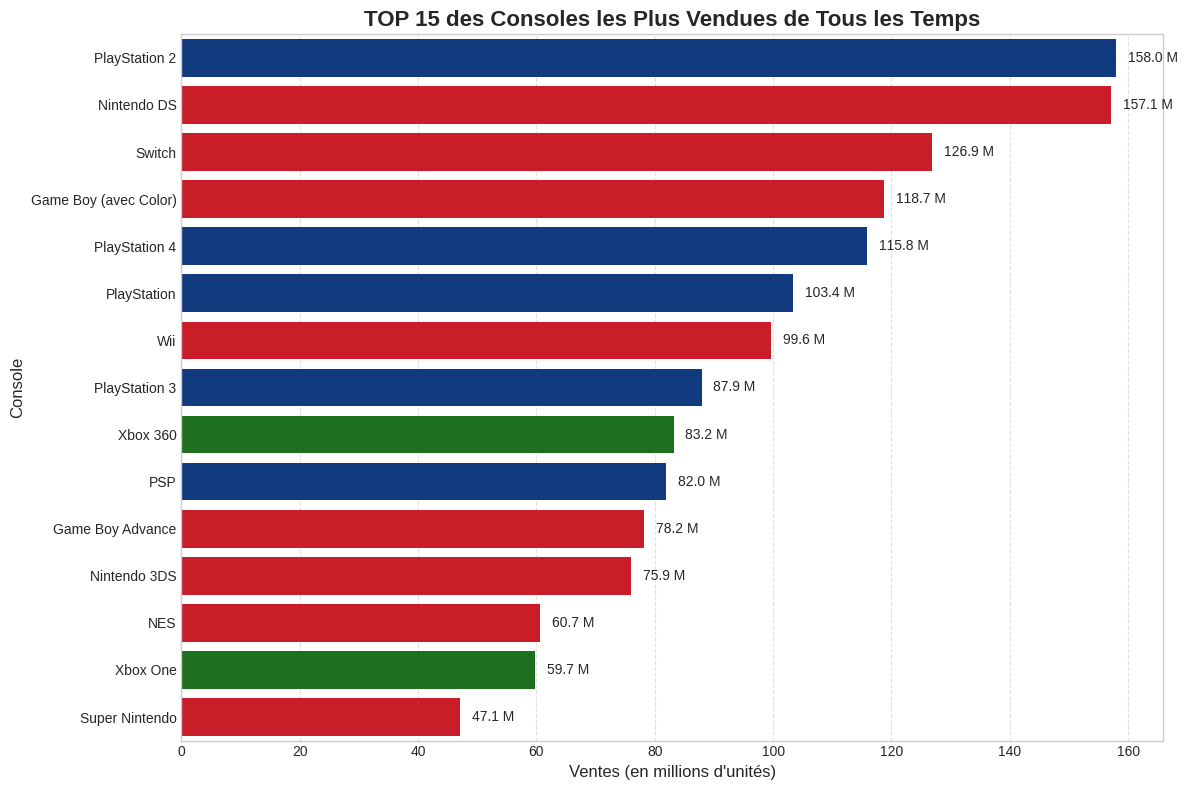

In [143]:
# Créer une palette de couleurs pour chaque constructeur pour la cohérence
palette_constructeurs = {
    'Sony': '#003791',       # Bleu PlayStation
    'Nintendo': '#E60012',   # Rouge Nintendo
    'Microsoft': '#107C10',  # Vert Xbox
    'Sega': '#0083C5',       # Bleu Sega
    'Atari': '#D4AF37'       # Or/Jaune Atari
}


# 1. Préparation des données
top_15_consoles = df_console.sort_values(by='Vente (en million)', ascending=False).head(15)

# 2. Création du graphique
plt.figure(figsize=(12, 8))


#  Seaborn
bars = sns.barplot(
    x='Vente (en million)',
    y='Console',
    data=top_15_consoles,
    hue='Constructeur',      # 1. On dit à Seaborn de colorer selon la colonne 'Constructeur'
    palette=palette_constructeurs, # 2. On donne le dictionnaire de couleurs.
    legend=False             # 3. On désactive la légende
)


# 3. Personnalisation
plt.title('TOP 15 des Consoles les Plus Vendues de Tous les Temps', fontsize=16, fontweight='bold')
plt.xlabel('Ventes (en millions d\'unités)', fontsize=12)
plt.ylabel('Console', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Ajouter les valeurs exactes sur chaque barre
for bar in bars.patches:
    width = bar.get_width()
    plt.text(width + 2, bar.get_y() + bar.get_height()/2, f'{width:,.1f} M', va='center')

plt.tight_layout()
plt.show()

Ce que ce graphique montre l'échelle immense du marché. Il introduit aussi subtilement la domination de Sony et Nintendo.

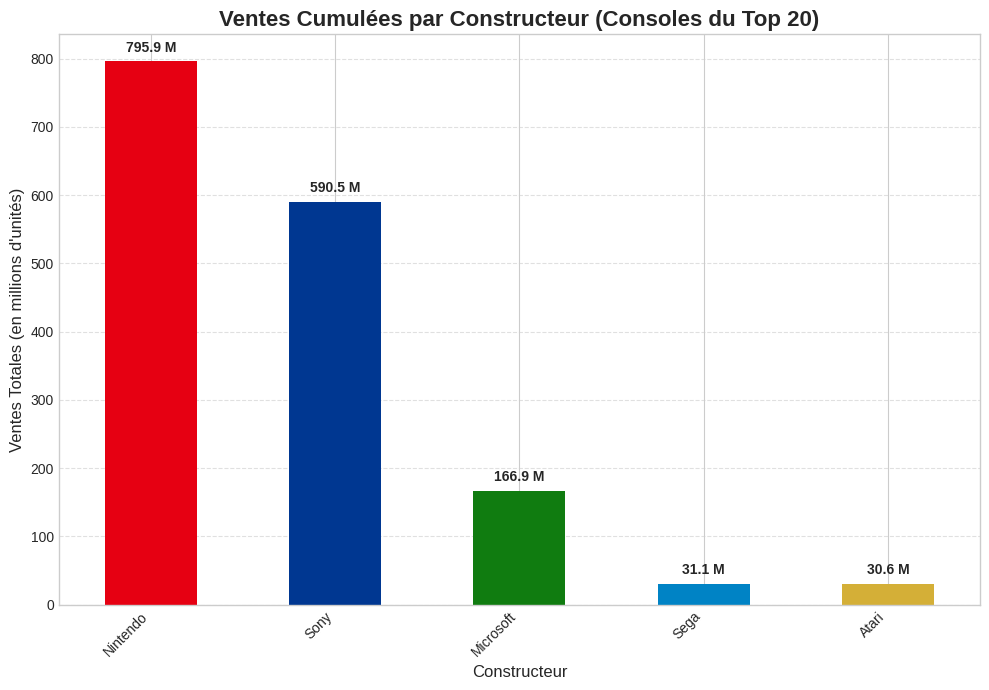

In [144]:
# 1. Préparation des données
ventes_par_constructeur = df_console.groupby('Constructeur')['Vente (en million)'].sum().sort_values(ascending=False)

# 2. Création du graphique
plt.figure(figsize=(10, 7))
bars = ventes_par_constructeur.plot(
    kind='bar',
    color=[palette_constructeurs.get(x, '#888888') for x in ventes_par_constructeur.index]
)

# 3. Personnalisation
plt.title('Ventes Cumulées par Constructeur (Consoles du Top 20)', fontsize=16, fontweight='bold')
plt.xlabel('Constructeur', fontsize=12)
plt.ylabel('Ventes Totales (en millions d\'unités)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Ajouter les totaux sur les barres
for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 10, f'{height:,.1f} M', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

Message clé : "Ce marché n'est pas fragmenté. Il est dominé par 3 géants qui ont vendu des centaines de millions de consoles au total."

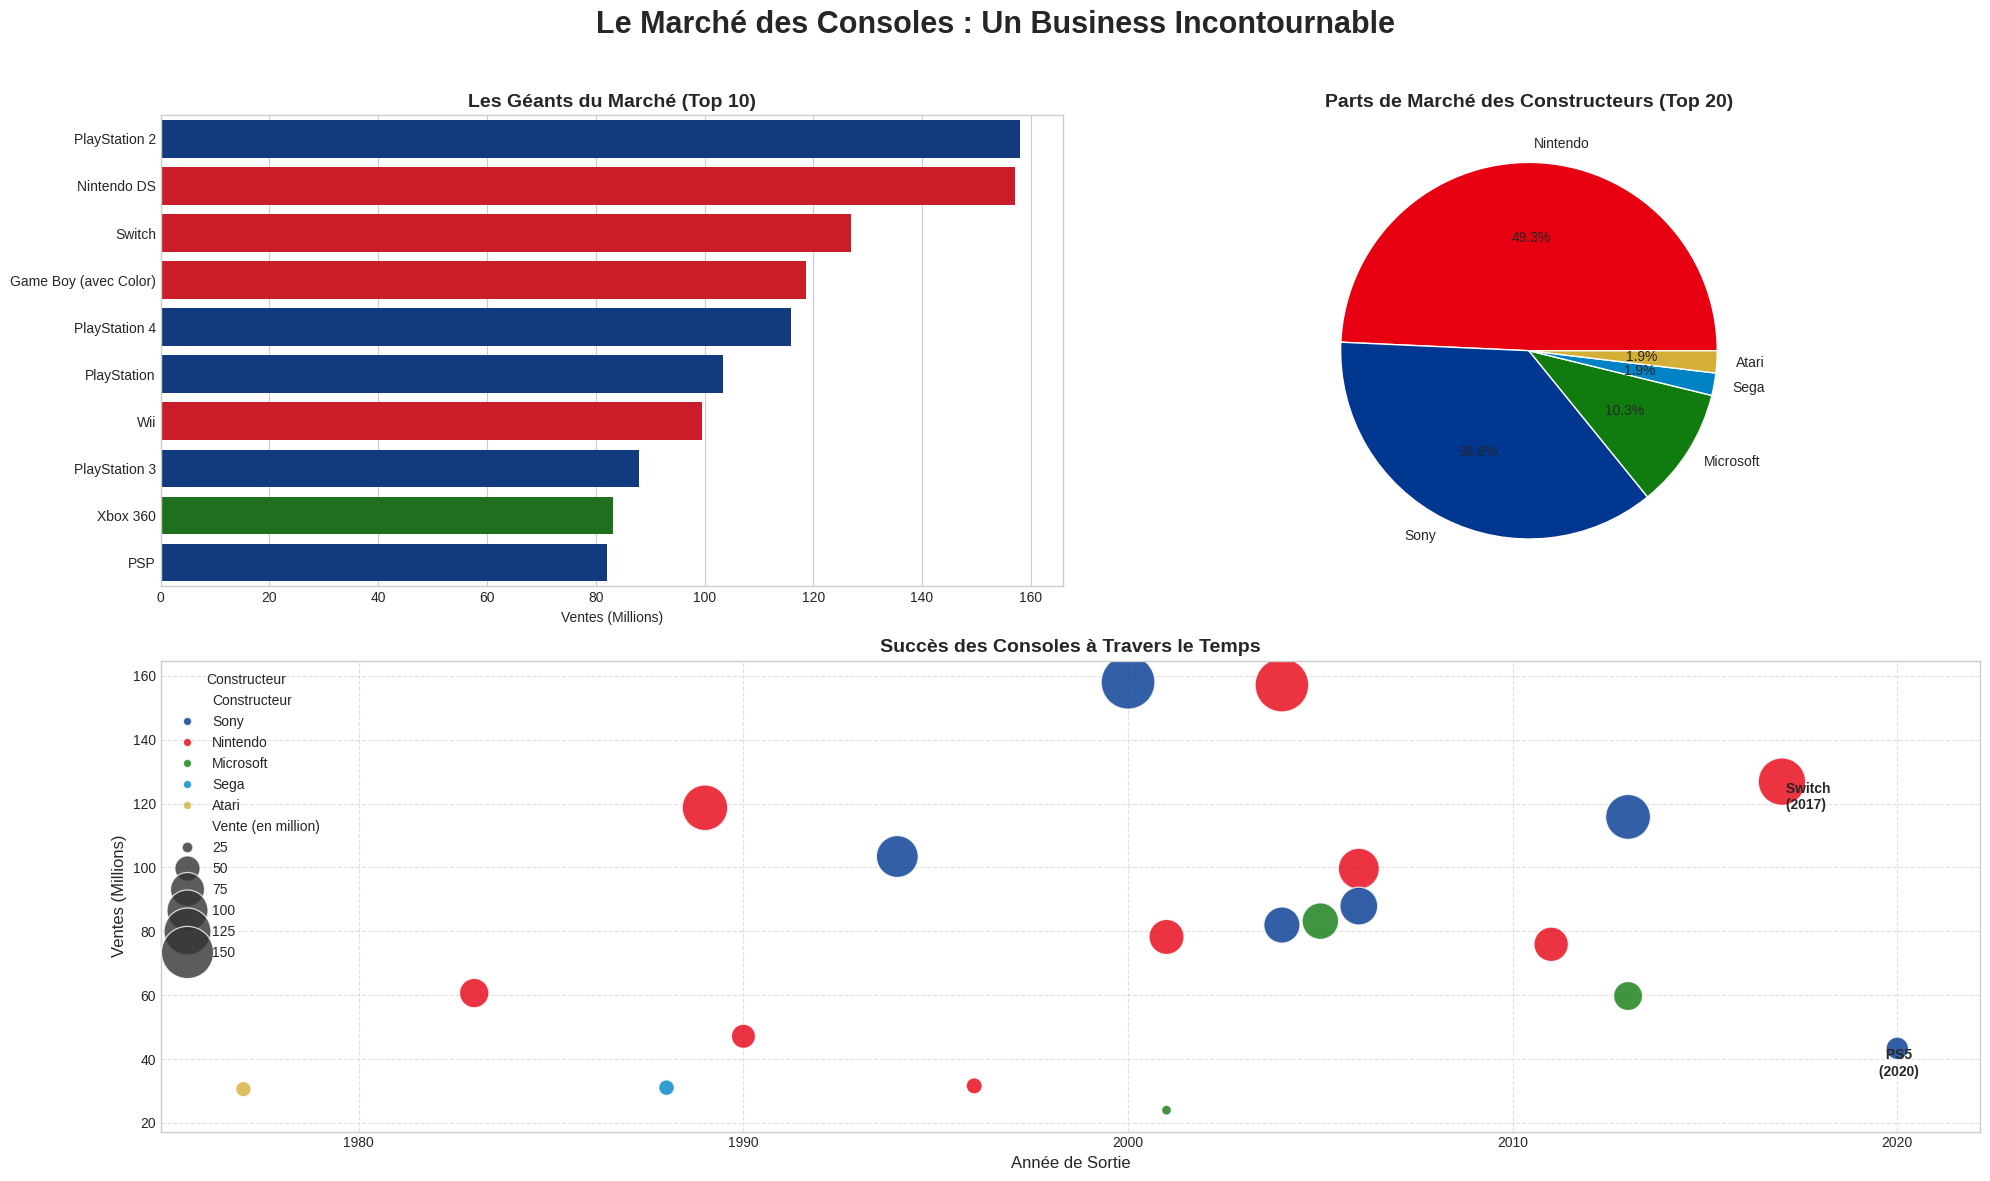

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Création de la figure
fig = plt.figure(figsize=(20, 12))
fig.suptitle('Le Marché des Consoles : Un Business Incontournable', fontsize=22, fontweight='bold')

# Définition d'une grille personnalisée : 2 lignes, 2 colonnes
gs = GridSpec(2, 2, figure=fig)

# Le premier graphique prend la case en haut à gauche (ligne 0, colonne 0)
ax1 = fig.add_subplot(gs[0, 0])
# Le deuxième graphique prend la case en haut à droite (ligne 0, colonne 1)
ax2 = fig.add_subplot(gs[0, 1])
# Le troisième graphique prend TOUTES les colonnes de la deuxième ligne
ax3 = fig.add_subplot(gs[1, :])

# --- GRAPHIQUE 1 ---
top_10 = df_console.head(10)
sns.barplot(x='Vente (en million)', y='Console', data=top_10, hue='Constructeur', palette=palette_constructeurs, legend=False, ax=ax1)
ax1.set_title('Les Géants du Marché (Top 10)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Ventes (Millions)')
ax1.set_ylabel('')

# --- GRAPHIQUE 2  ---
ventes_par_constructeur = df_console.groupby('Constructeur')['Vente (en million)'].sum().sort_values(ascending=False)
ventes_par_constructeur.plot(kind='pie', ax=ax2, autopct='%1.1f%%', colors=[palette_constructeurs.get(x) for x in ventes_par_constructeur.index], wedgeprops={'edgecolor': 'white'})
ax2.set_title('Parts de Marché des Constructeurs (Top 20)', fontsize=14, fontweight='bold')
ax2.set_ylabel('')

# --- GRAPHIQUE 3  ---
sns.scatterplot(data=df_console, x='Date de Sortie', y='Vente (en million)', hue='Constructeur', size='Vente (en million)', sizes=(50, 1500), palette=palette_constructeurs, alpha=0.8, ax=ax3)
ax3.set_title('Succès des Consoles à Travers le Temps', fontsize=14, fontweight='bold')
ax3.set_xlabel('Année de Sortie', fontsize=12)
ax3.set_ylabel('Ventes (Millions)', fontsize=12)
ax3.grid(True, linestyle='--', alpha=0.6)
ax3.legend(title='Constructeur')

# Mettre en évidence les consoles récentes et très performantes
switch = df_console[df_console['Console'] == 'Switch']
ps5 = df_console[df_console['Console'] == 'PlayStation 5']
ax3.text(switch['Date de Sortie'].iloc[0], switch['Vente (en million)'].iloc[0], ' Switch\n (2017)', ha='left', va='top', fontweight='bold')
ax3.text(ps5['Date de Sortie'].iloc[0], ps5['Vente (en million)'].iloc[0], ' PS5\n (2020)', ha='center', va='top', fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

 "Le marché des consoles est un business colossal, dominé par des géants, et qui continue de générer des succès massifs, comme le prouve la Switch sortie en 2017."

# AMELIORATION DES DONNEES :

 il faut des données récentes  ventes des consoles actuelles, donnees en prenant en compte els ventes dematerialisées (D’après les données de l’IDATE, en 2018, le jeu vidéo dématérialisé représente 78,7 % du marché du jeu vidéo total en France et cela devrait continuer à progresser dans les prochaines années.)

On va recueperer les ventes de consoles plus récentes sur kaggle

In [146]:
!pip -q install -U kagglehub

import kagglehub
import pandas as pd
import glob
import os

# Téléchargement du dataset
path = kagglehub.dataset_download("lucasgalanti/home-consoles-and-gaming-sales")
print("Dossier local :", path)

# Liste tous les CSV présents
csvs = glob.glob(path + "/**/*.csv", recursive=True)
print("CSV trouvés :", csvs)

# Vérifie que Console_Data.csv est présent
console_csv = [f for f in csvs if os.path.basename(f).lower() == "console_data.csv".lower()]
assert console_csv, "Console_Data.csv introuvable dans ce dataset."

# Lecture du CSV
df_console_2024 = pd.read_csv(console_csv[0])
df_console_2024.head()


Dossier local : /kaggle/input/home-consoles-and-gaming-sales
CSV trouvés : ['/kaggle/input/home-consoles-and-gaming-sales/Console_Data.csv', '/kaggle/input/home-consoles-and-gaming-sales/scrapped_data.csv']


,Console Name,Type,Company,Gen,Gen Years,Released Year,Generation,Discontinuation Year,Units sold (million),Remarks,Link to gif
0,Magnavox Odyssey,Home,Magnavox,1st Gen,1972-1978,1972,1,1975,0.35,The Magnavox Odyssey is the first commercial ...,https://s12.gifyu.com/images/SVLO3.gif
1,Home Pong,Home,Atari,1st Gen,1972-1978,1975,1,1978,0.15,Atari's Home Pong was a dedicated console that...,https://s12.gifyu.com/images/SVz99.gif
2,Atari 2600,Home,Atari,2nd Gen,1978-1982,1977,2,1992,30.00,Atari2600 is often credited with popularizing ...,https://s12.gifyu.com/images/SVz3U.gif
3,Magnavox Odyssey 2,Home,Magnavox,2nd Gen,1978-1982,1978,2,1984,2.00,The Odyssey² featured a built-in keyboard for ...,https://s12.gifyu.com/images/SVz70.gif
4,Intellivision,Home,Mattel,2nd Gen,1978-1982,1979,2,1990,3.00,The Intellivision boasted superior graphics an...,https://s12.gifyu.com/images/SVLBF.gif


In [147]:
df_console_2024.head(100)

,Console Name,Type,Company,Gen,Gen Years,Released Year,Generation,Discontinuation Year,Units sold (million),Remarks,Link to gif
0,Magnavox Odyssey,Home,Magnavox,1st Gen,1972-1978,1972,1,1975,0.35,The Magnavox Odyssey is the first commercial ...,https://s12.gifyu.com/images/SVLO3.gif
1,Home Pong,Home,Atari,1st Gen,1972-1978,1975,1,1978,0.15,Atari's Home Pong was a dedicated console that...,https://s12.gifyu.com/images/SVz99.gif
2,Atari 2600,Home,Atari,2nd Gen,1978-1982,1977,2,1992,30.00,Atari2600 is often credited with popularizing ...,https://s12.gifyu.com/images/SVz3U.gif
3,Magnavox Odyssey 2,Home,Magnavox,2nd Gen,1978-1982,1978,2,1984,2.00,The Odyssey² featured a built-in keyboard for ...,https://s12.gifyu.com/images/SVz70.gif
4,Intellivision,Home,Mattel,2nd Gen,1978-1982,1979,2,1990,3.00,The Intellivision boasted superior graphics an...,https://s12.gifyu.com/images/SVLBF.gif
5,Atari 5200/7800,Home,Atari,3rd Gen,1982-1988,1982,3,1984,2.00,Launched in 1982 as a successor to the Atari 2...,https://s12.gifyu.com/images/SVzdV.gif
6,Nintendo Entertainment System,Home,Nintendo,3rd Gen,1982-1988,1983,3,1995,62.00,The NES not only revitalized the gaming indust...,https://s12.gifyu.com/images/SVzpe.gif
7,Sega Master System,Home,Sega,3rd Gen,1982-1988,1986,3,1996,13.00,"Released as a competitor to the NES, the Maste...",https://s12.gifyu.com/images/SVzhn.gif
8,Sega Genesis,Home,Sega,4th Gen,1988-1994,1988,4,1997,33.00,The Mega Drive's 'Blast Processing' marketing ...,https://s12.gifyu.com/images/SVzNV.gif
9,Super Nintendo,Home,Nintendo,4th Gen,1988-1994,1990,4,2003,49.00,"In addition to its stellar first-party lineup,...",https://s12.gifyu.com/images/SVzLW.gif


on refait le nuage de point de console avec les nouvelles données en ameliorant un peu

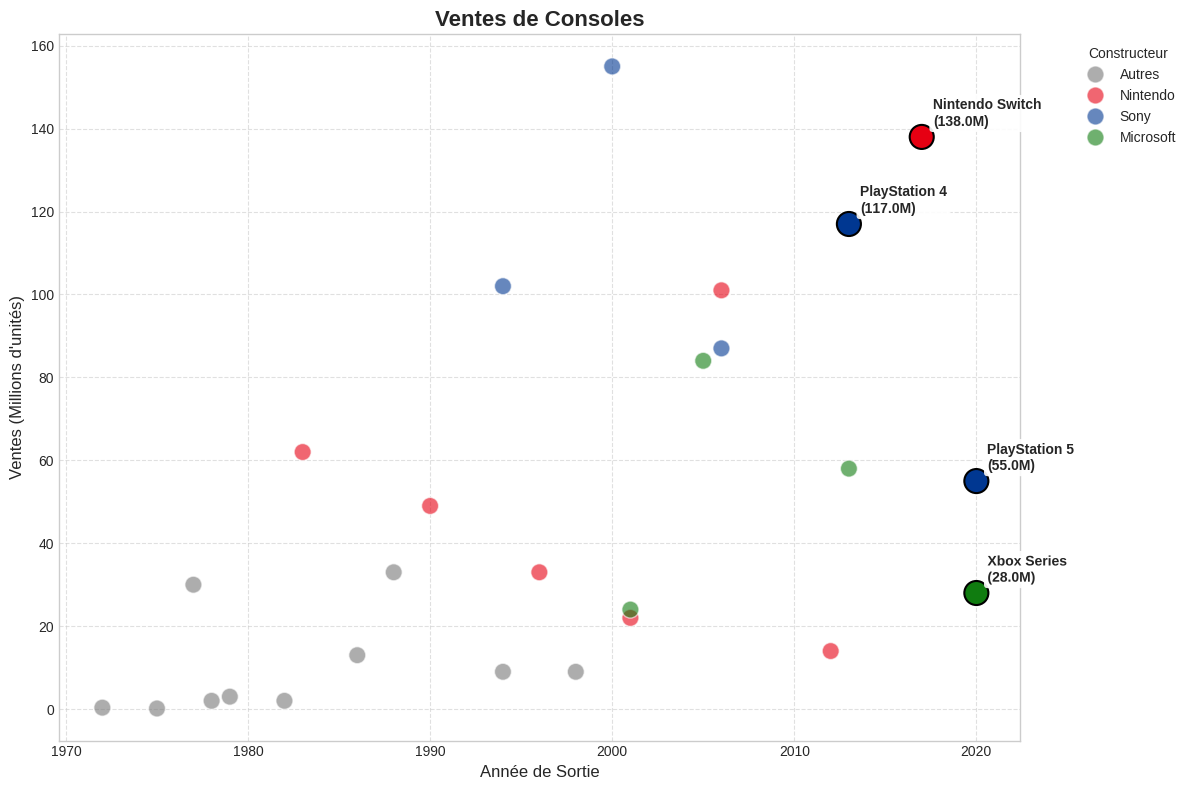

In [148]:
palette_constructeurs = {
    'Sony': '#003791',
    'Nintendo': '#E60012',
    'Microsoft': '#107C10',
    'Autres': '#777777'   # couleur pour tout le reste
}

df_console_2024['Company_plot'] = np.where(
    df_console_2024['Company'].isin(palette_constructeurs.keys()),
    df_console_2024['Company'],
    'Autres'
)

# Filtre pour les consoles en cours (ongoing)
df_ongoing = df_console_2024[df_console_2024['Discontinuation Year'] == 'ongoing'].copy()

plt.figure(figsize=(12, 8))

# Plot toutes les consoles
sns.scatterplot(
    data=df_console_2024,
    x='Released Year',
    y='Units sold (million)',
    hue='Company_plot',
    palette=palette_constructeurs,
    alpha=0.6,
    s=150 # 's' pour une taille fixe pour tous les points
)

# Mettre en évidence les consoles en cours (ongoing)
sns.scatterplot(
    data=df_ongoing,
    x='Released Year',
    y='Units sold (million)',
    hue='Company_plot',
    palette=palette_constructeurs,
    s=300, # Une taille un peu plus grande
    alpha=1,
    edgecolor='black',
    linewidth=1.5,
    legend=False
)


plt.title('Ventes de Consoles', fontsize=16, fontweight='bold')
plt.xlabel('Année de Sortie', fontsize=12)
plt.ylabel('Ventes (Millions d\'unités)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Constructeur', bbox_to_anchor=(1.05, 1), loc='upper left')




import matplotlib.patheffects as pe

ax = plt.gca()
texts = []

# Ordre par taille pour que les gros labels soient posés d'abord
for _, r in df_ongoing.sort_values('Units sold (million)', ascending=False).iterrows():
    txt = ax.annotate(
        f"{r['Console Name']}\n({r['Units sold (million)']:.1f}M)",
        xy=(r['Released Year'], r['Units sold (million)']),
        xytext=(8, 6), textcoords='offset points',  # petit décalage
        ha='left', va='bottom',
        fontsize=10, fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.25', fc='white', alpha=0.9, ec='none'),
        zorder=5, clip_on=False
    )
    # Halo blanc autour du texte (encore plus lisible sur fonds chargés)
txt.set_path_effects([pe.withStroke(linewidth=3, foreground='white')])
texts.append(txt)

plt.tight_layout()
plt.show()

# CONTEXTE FRANCE

In [149]:
#telechargement du xlsx mis à disposition sur le site data.gouv.fr
#https://www.data.gouv.fr/api/1/datasets/r/3ceb3483-c83e-4b79-b3a8-078c89f8e96e

import pandas as pd

url = "https://www.data.gouv.fr/api/1/datasets/r/3ceb3483-c83e-4b79-b3a8-078c89f8e96e"

df_France = pd.read_excel(url, sheet_name=None)

# Afficher les noms des feuilles disponibles
print("Feuilles disponibles:")
for sheet_name in df_France.keys():
    print(f"- {sheet_name}")

print("\n" + "="*50 + "\n")

# Accéder à chaque feuille individuellement
for sheet_name, df in df_France.items():
    print(f"Feuille '{sheet_name}': {df.shape[0]} lignes, {df.shape[1]} colonnes")
    print(f"Premières lignes de '{sheet_name}':")
    display(df.head())
    print("\n" + "-"*30 + "\n")

Feuilles disponibles:
- Sommaire
- Définitions
- écosysteme
- segment
- logiciel
- genreConsole
- genrePC
- PEGIConsole
- PEGIPC
- ESRI_MAPINFO_SHEET


Feuille 'Sommaire': 15 lignes, 2 colonnes
Premières lignes de 'Sommaire':


,Unnamed: 0,Unnamed: 1
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,MARCHE DU JEU VIDEO,NaN
4,NaN,NaN



------------------------------

Feuille 'Définitions': 15 lignes, 1 colonnes
Premières lignes de 'Définitions':


,Unnamed: 0
0,"Retour au menu ""Marché du jeu vidéo"""
1,NaN
2,Définitions
3,NaN
4,NaN



------------------------------

Feuille 'écosysteme': 20 lignes, 9 colonnes
Premières lignes de 'écosysteme':


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,"Retour au menu ""Marché du jeu vidéo""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Marché des jeux vidéo selon l'écosystème,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Chiffre d’affaires du marché du jeu vidéo selo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



------------------------------

Feuille 'segment': 52 lignes, 9 colonnes
Premières lignes de 'segment':


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,"Retour au menu ""Marché du jeu vidéo""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Marché du jeu vidéo selon le segment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Chiffre d’affaires du marché du jeu vidéo selo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



------------------------------

Feuille 'logiciel': 20 lignes, 9 colonnes
Premières lignes de 'logiciel':


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,"Retour au menu ""Marché du jeu vidéo""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Marché des jeux vidéo selon les supports de le...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Chiffre d’affaires du marché des jeux vidéo se...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



------------------------------

Feuille 'genreConsole': 81 lignes, 9 colonnes
Premières lignes de 'genreConsole':


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,"Retour au menu ""Marché du jeu vidéo""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Marché du jeu vidéo console selon le genre,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Le marché des jeux vidéo console selon le genr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



------------------------------

Feuille 'genrePC': 82 lignes, 9 colonnes
Premières lignes de 'genrePC':


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,"Retour au menu ""Marché du jeu vidéo""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Marché du jeu vidéo PC selon le genre,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Le marché des jeux vidéo PC selon le genre (mi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



------------------------------

Feuille 'PEGIConsole': 48 lignes, 10 colonnes
Premières lignes de 'PEGIConsole':


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,"Retour au menu ""Marché du jeu vidéo""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Marché du jeu vidéo console selon la classific...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Le marché des jeux vidéo console selon la clas...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



------------------------------

Feuille 'PEGIPC': 49 lignes, 10 colonnes
Premières lignes de 'PEGIPC':


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,"Retour au menu ""Marché du jeu vidéo""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Marché du jeu vidéo PC selon la classification...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Le marché des jeux vidéo PC selon la classific...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



------------------------------

Feuille 'ESRI_MAPINFO_SHEET': 0 lignes, 0 colonnes
Premières lignes de 'ESRI_MAPINFO_SHEET':


""



------------------------------



In [150]:
#feuille écosystème/segment
df_France_ecosysteme = df_France["segment"]


In [151]:

# Extraire les en-têtes de la ligne
headers = df_France_ecosysteme.iloc[24].tolist()
headers[0] = "ecosysteme"
# Afficher les en-têtes extraits
print(f"\nEn-têtes extraits de la ligne 6: {headers}")
data_rows = df_France_ecosysteme.iloc[25:36]



df_France_ecosysteme_clean = pd.DataFrame(data_rows.values, columns=headers)

df_France_ecosysteme_clean.columns = [
    int(col) if str(col).replace('.', '', 1).isdigit() else col
    for col in df_France_ecosysteme_clean.columns
]
df_France_ecosysteme_clean.head(15)



En-têtes extraits de la ligne 6: ['ecosysteme', 2017, 2018, 2019, np.float64(2020.0), np.float64(2021.0), np.float64(2022.0), np.float64(2023.0), np.float64(2024.0)]


,ecosysteme,2017,2018,2019,2020,2021,2022,2023,2024
0,matériel console,784,777,611.904,658.0,760.0,615.0,1059.0,692.391476
1,accessoire console,272,278,243,271.0,297.0,289.0,342.0,328.260737
2,logiciel physique console,795,775,688.316,668.0,600.0,622.0,614.0,450.709628
3,logiciel dématérialisé console,550,919,916.096741,1091.326671,1057.424729,1011.0,1134.0,1083.0
4,matériel PC,672.232196,673.665497,633.160707,771.0,940.96,914.0,674.0,755.02
5,accessoire PC,133,148,155,59.0,73.0,60.0,57.0,74.729034
6,écrans PC,-,-,-,127.0,145.0,118.0,160.0,201.0
7,logiciel physique PC,24,18,10.376,8.222459,5.373,3.0,1.8,1.8
8,logiciel dématérialisé PC,463,618,490.451617,483.233773,333.0,470.0,499.0,486.0
9,logiciel mobile,778,965,1231,1425.697227,1411.0,1415.0,1483.0,1604.0


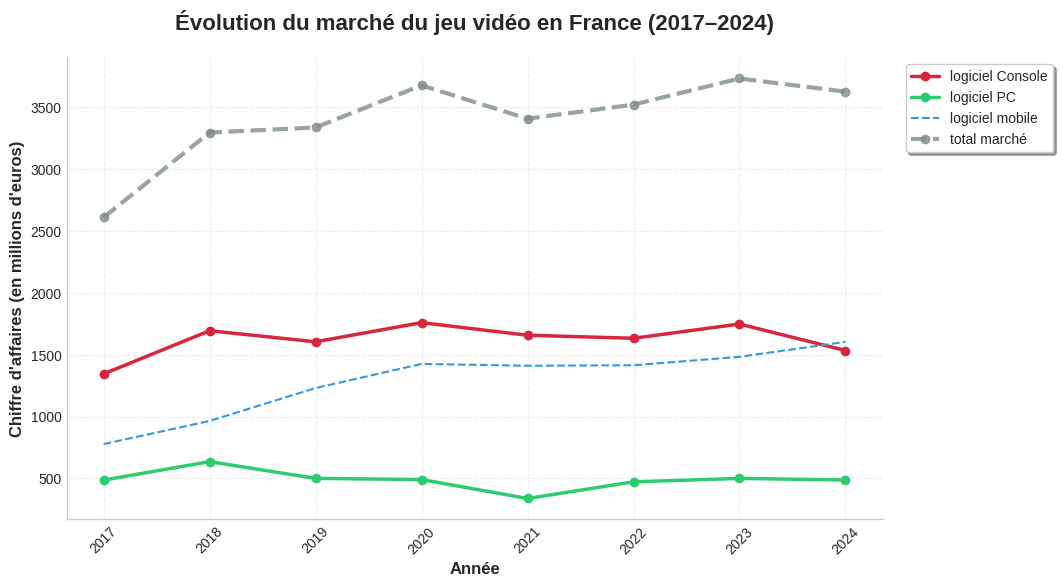

In [152]:


# === 1) Styles ===
colors = {
    'logiciel Console': '#D7263D',   # Rouge
    'logiciel PC': '#2ECC71',        # Vert
    'logiciel mobile': '#3498DB',    # Bleu
    'total marché': '#7F8C8D'        # Gris (calculé)
}

line_styles = {
    'logiciel Console': '-',
    'logiciel PC': '-',
    'logiciel mobile': '--',   # mobile en pointillé
    'total marché': '--'       # total en pointillé
}

line_widths = {
    'logiciel Console': 2.5,
    'logiciel PC': 2.5,
    'logiciel mobile': 1.5,
    'total marché': 3
}

# === 2) Normaliser les colonnes années ===
year_cols = [
    int(c) for c in df_France_ecosysteme_clean.columns
    if (isinstance(c, (int, float)) or (isinstance(c, str) and c.replace('.', '', 1).isdigit()))
       and c != 'ecosysteme'
]
year_cols = sorted(year_cols)

# === 3) Mapping d'agrégation ===
mapping = {
    'logiciel physique console': 'logiciel Console',
    'logiciel dématérialisé console': 'logiciel Console',
    'logiciel physique PC': 'logiciel PC',
    'logiciel dématérialisé PC': 'logiciel PC',
    'logiciel mobile': 'logiciel mobile'
}

# Filtrer les lignes utiles puis remapper
df_tmp = df_France_ecosysteme_clean[
    df_France_ecosysteme_clean['ecosysteme'].isin(mapping.keys())
].copy()

df_tmp['ecosysteme'] = df_tmp['ecosysteme'].map(mapping)
df_tmp[year_cols] = df_tmp[year_cols].apply(pd.to_numeric, errors='coerce').fillna(0.0)

# Agréger par écosystème (somme des lignes mappées)
df_grouped = df_tmp.groupby('ecosysteme', as_index=False)[year_cols].sum()

# === 4) Calculer le total marché (somme des séries affichées) ===
present = [e for e in ['logiciel Console', 'logiciel PC', 'logiciel mobile'] if e in df_grouped['ecosysteme'].values]
total_vals = df_grouped.set_index('ecosysteme').loc[present, year_cols].sum(axis=0)

row_total = pd.DataFrame([{'ecosysteme': 'total marché', **{y: total_vals[y] for y in year_cols}}])

# DF final pour le tracé
df_plot = pd.concat([df_grouped, row_total], ignore_index=True)

# === 5) Tracé ===
fig, ax = plt.subplots(figsize=(12, 6))

for _, row in df_plot.iterrows():
    eco = row['ecosysteme']
    values = [row[y] for y in year_cols]

    ax.plot(
        year_cols, values,
        color=colors.get(eco, '#666666'),
        linestyle=line_styles.get(eco, '-'),
        linewidth=line_widths.get(eco, 2),
        marker=None if eco == 'logiciel mobile' else 'o',  # pas de points pour mobile
        markersize=6,
        label=eco,
        alpha=0.8 if eco == 'total marché' else 1.0
    )

# === 6) Habillage ===
ax.set_title("Évolution du marché du jeu vidéo en France (2017–2024)", fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Année', fontsize=12, fontweight='bold')
ax.set_ylabel("Chiffre d'affaires (en millions d'euros)", fontsize=12, fontweight='bold')

ax.set_xticks(year_cols)
ax.set_xticklabels(year_cols, rotation=45)
ax.grid(True, alpha=0.3, linestyle='--')

ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', frameon=True, fancybox=True, shadow=True)
fig.subplots_adjust(left=0.1, right=0.78)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()


regression linéaire pour previsionnel

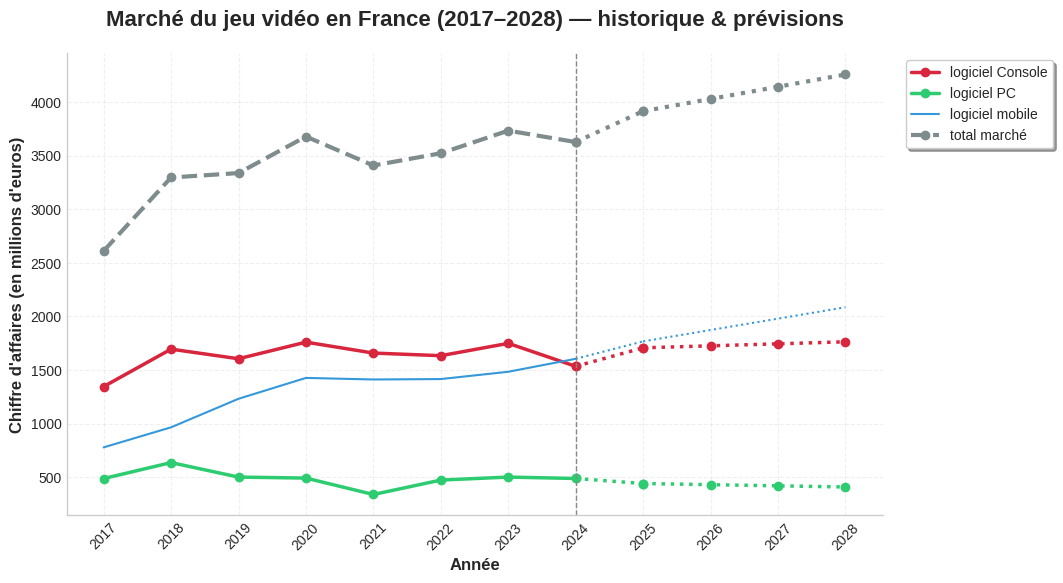

In [153]:
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

# --- On repart de df_tmp déjà créé plus haut (mappé, nettoyé) ---
# df_tmp contient les lignes "logiciel Console", "logiciel PC", "logiciel mobile" (agrégées)

# Années historiques et années de prévision
hist_years = sorted([int(c) for c in df_tmp.columns
                     if (isinstance(c, (int, float)) or (isinstance(c, str) and c.replace('.', '', 1).isdigit()))
                     and c != 'ecosysteme' and int(float(c)) <= 2024])
fcst_years = list(range(2025, 2029))  # 2025–2028

# Agrégation historique
df_grouped_hist = df_tmp.groupby('ecosysteme', as_index=False)[hist_years].sum().set_index('ecosysteme')
series_cibles = [s for s in ['logiciel Console', 'logiciel PC', 'logiciel mobile'] if s in df_grouped_hist.index]

# Prévisions par régression linéaire (sklearn)
preds = {}
for eco in series_cibles:
    y_hist = df_grouped_hist.loc[eco, hist_years].to_numpy(dtype=float)
    x_hist = np.array(hist_years, dtype=float).reshape(-1, 1)

    model = LinearRegression()
    model.fit(x_hist, y_hist)

    x_fcst = np.array(fcst_years).reshape(-1, 1)
    y_fcst = model.predict(x_fcst)
    y_fcst = np.clip(y_fcst, a_min=0, a_max=None)  # sécurité

    preds[eco] = y_fcst

# Total marché (hist + prévision)
hist_total = np.sum([df_grouped_hist.loc[s, hist_years].to_numpy(dtype=float) for s in series_cibles], axis=0)
fcst_total = np.sum([preds[s] for s in series_cibles], axis=0)
df_grouped_hist.loc['total marché', hist_years] = hist_total
preds['total marché'] = fcst_total

# === Styles (reprend tes palettes) ===
colors = {
    'logiciel Console': '#D7263D',
    'logiciel PC': '#2ECC71',
    'logiciel mobile': '#3498DB',
    'total marché': '#7F8C8D'
}
line_widths = {
    'logiciel Console': 2.5,
    'logiciel PC': 2.5,
    'logiciel mobile': 1.5,
    'total marché': 3
}

# === Tracé combiné ===
fig, ax = plt.subplots(figsize=(12, 6))

for eco in ['logiciel Console', 'logiciel PC', 'logiciel mobile', 'total marché']:
    if eco not in df_grouped_hist.index:  # au cas où une série manque
        continue

    # Historique 2017–2024
    y_hist = df_grouped_hist.loc[eco, hist_years].to_numpy(dtype=float)
    ax.plot(
        hist_years, y_hist,
        color=colors.get(eco, '#666666'),
        linestyle='--' if eco == 'total marché' else '-',
        linewidth=line_widths.get(eco, 2),
        marker=None if eco == 'logiciel mobile' else 'o',
        markersize=6,
        label=eco
    )

    # Prévision 2025–2028 (pointillé)
    y_fcst = preds.get(eco, None)
    if y_fcst is not None:
        # petit segment de liaison 2024-2025 en pointillé
        ax.plot(
            [hist_years[-1], fcst_years[0]],
            [y_hist[-1], y_fcst[0]],
            color=colors.get(eco, '#666666'),
            linestyle=':',
            linewidth=line_widths.get(eco, 2),
            marker=None if eco == 'logiciel mobile' else 'o',
            markersize=6,
            label='_nolegend_'
        )
        # segment prévision (pointillé)
        ax.plot(
            fcst_years, y_fcst,
            color=colors.get(eco, '#666666'),
            linestyle=':',
            linewidth=line_widths.get(eco, 2),
            marker=None if eco == 'logiciel mobile' else 'o',
            markersize=6,
            label='_nolegend_'
        )

# Axe & habillage
all_years = hist_years + fcst_years
ax.set_title("Marché du jeu vidéo en France (2017–2028) — historique & prévisions", fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Année', fontsize=12, fontweight='bold')
ax.set_ylabel("Chiffre d'affaires (en millions d'euros)", fontsize=12, fontweight='bold')
ax.set_xticks(all_years)
ax.set_xticklabels(all_years, rotation=45)
ax.grid(True, alpha=0.3, linestyle='--')

# Marque la zone de prévision (optionnel mais utile)
ax.axvline(x=2024, color='#888', linestyle='--', linewidth=1)


ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', frameon=True, fancybox=True, shadow=True)
fig.subplots_adjust(left=0.1, right=0.78)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()


essai avec la methode Holt-Winters meilleure sur les séries temporelles

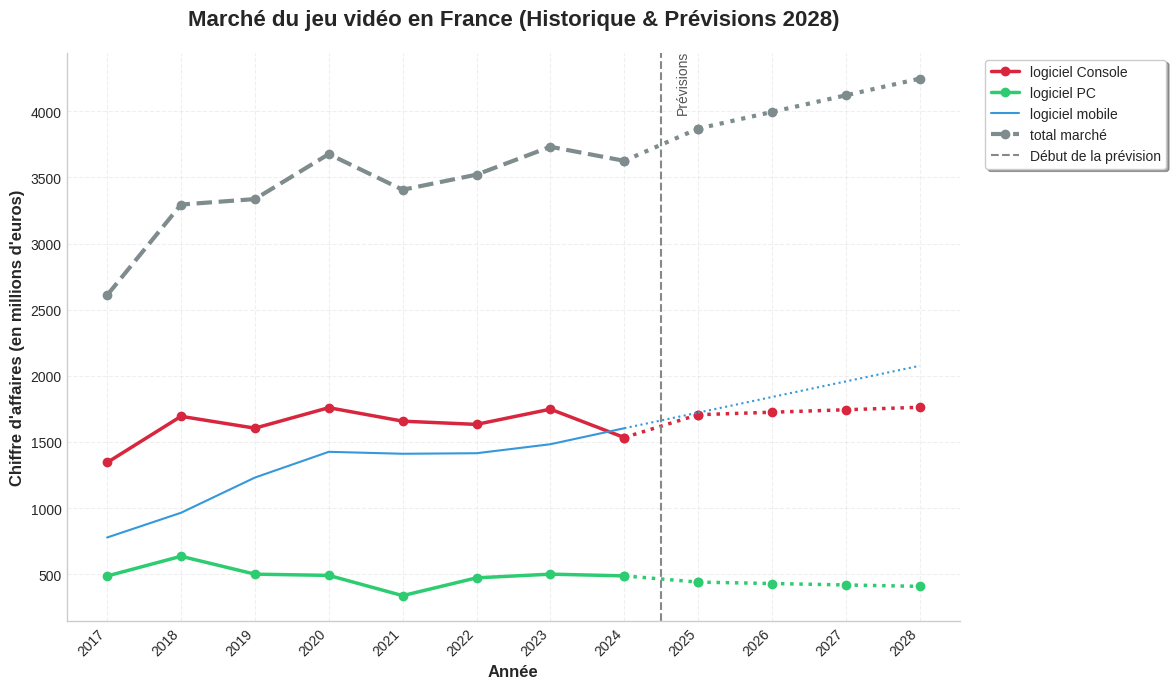

In [154]:
from statsmodels.tsa.api import ExponentialSmoothing


# Années historiques et années de prévision
hist_years = sorted([int(c) for c in df_tmp.columns
                     if (isinstance(c, (int, float)) or (isinstance(c, str) and c.replace('.', '', 1).isdigit()))
                     and c != 'ecosysteme' and int(float(c)) <= 2024])
fcst_years = list(range(2025, 2029))  # Prévision pour 2025–2028

# Agrégation des données historiques par écosystème
df_grouped_hist = df_tmp.groupby('ecosysteme', as_index=False)[hist_years].sum().set_index('ecosysteme')
series_cibles = [s for s in ['logiciel Console', 'logiciel PC', 'logiciel mobile'] if s in df_grouped_hist.index]



preds = {}
for eco in series_cibles:
    y_hist = df_grouped_hist.loc[eco, hist_years].to_numpy(dtype=float)

    # Création et entraînement du modèle de Holt

    model = ExponentialSmoothing(
        y_hist,
        trend='add',  # Tendance additive (croissance/décroissance linéaire)
        initialization_method='estimated'
    ).fit()

    # Prévision pour le nombre d'années futures défini
    n_forecast = len(fcst_years)
    y_fcst = model.forecast(n_forecast)

    # Sécurité pour ne pas avoir de valeurs de revenus négatives
    y_fcst = np.clip(y_fcst, a_min=0, a_max=None)

    preds[eco] = y_fcst

# Calcul du total marché (historique + prévision)
hist_total = np.sum([df_grouped_hist.loc[s, hist_years].to_numpy(dtype=float) for s in series_cibles], axis=0)
fcst_total = np.sum([preds[s] for s in series_cibles], axis=0)
df_grouped_hist.loc['total marché', hist_years] = hist_total
preds['total marché'] = fcst_total



# parametrage du graph

colors = {
    'logiciel Console': '#D7263D',
    'logiciel PC': '#2ECC71',
    'logiciel mobile': '#3498DB',
    'total marché': '#7F8C8D'
}
line_widths = {
    'logiciel Console': 2.5,
    'logiciel PC': 2.5,
    'logiciel mobile': 1.5,
    'total marché': 3
}



#  graphique combiné (HISTORIQUE + PRÉVISIONS)

fig, ax = plt.subplots(figsize=(14, 7))

for eco in ['logiciel Console', 'logiciel PC', 'logiciel mobile', 'total marché']:
    if eco not in df_grouped_hist.index:
        continue

    # Tracer l'historique (2017–2024)
    y_hist = df_grouped_hist.loc[eco, hist_years].to_numpy(dtype=float)
    ax.plot(
        hist_years, y_hist,
        color=colors.get(eco, '#666666'),
        linestyle='-' if eco != 'total marché' else '--',
        linewidth=line_widths.get(eco, 2),
        marker=None if eco == 'logiciel mobile' else 'o',
        markersize=6,
        label=eco
    )

    #Tracer les prévisions (2025–2028)
    y_fcst = preds.get(eco, None)
    if y_fcst is not None:
        # Segment de liaison (2024 -> 2025) en pointillé
        ax.plot(
            [hist_years[-1], fcst_years[0]],
            [y_hist[-1], y_fcst[0]],
            color=colors.get(eco, '#666666'),
            linestyle=':',
            linewidth=line_widths.get(eco, 2),
            marker=None if eco == 'logiciel mobile' else 'o',
            markersize=6,
            label='_nolegend_' # Ne pas afficher dans la légende
        )
        # Ligne de prévision principale en pointillé
        ax.plot(
            fcst_years, y_fcst,
            color=colors.get(eco, '#666666'),
            linestyle=':',
            linewidth=line_widths.get(eco, 2),
            marker=None if eco == 'logiciel mobile' else 'o',
            markersize=6,
            label='_nolegend_'
        )

# Mise en forme et habillage du graphique
all_years = hist_years + fcst_years
ax.set_title("Marché du jeu vidéo en France (Historique & Prévisions 2028)", fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Année', fontsize=12, fontweight='bold')
ax.set_ylabel("Chiffre d'affaires (en millions d'euros)", fontsize=12, fontweight='bold')
ax.set_xticks(all_years)
ax.set_xticklabels(all_years, rotation=45, ha='right')
ax.grid(True, alpha=0.3, linestyle='--')

# Marquer visuellement la zone de prévision
ax.axvline(x=2024.5, color='#888', linestyle='--', linewidth=1.5, label='Début de la prévision')
ax.text(2024.7, ax.get_ylim()[1]*0.95, 'Prévisions', rotation=90, verticalalignment='center', color='#555')


ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', frameon=True, fancybox=True, shadow=True)
fig.tight_layout(rect=[0, 0, 0.85, 1]) # Ajuster pour laisser de la place à la légende
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

-->  Résultat identique a linear regression

on va faire un graph camembert du demat/physique

In [155]:
#preparation des données pour pie chart

year_cols = [
    int(c) for c in df_France_ecosysteme_clean.columns
    if (isinstance(c, (int, float)) or (isinstance(c, str) and c.replace('.', '', 1).isdigit()))
       and c != 'ecosysteme'
]
year_cols = sorted(year_cols)

# Mapping des lignes du DF vers les 4 séries utiles
mapping = {
    'logiciel physique console': 'console_phys',
    'logiciel dématérialisé console': 'console_dem',
    'logiciel physique PC': 'pc_phys',
    'logiciel dématérialisé PC': 'pc_dem',
}

# Filtrer les lignes utiles et remapper
df_use = df_France_ecosysteme_clean[
    df_France_ecosysteme_clean['ecosysteme'].isin(mapping.keys())
].copy()
df_use['mapped'] = df_use['ecosysteme'].map(mapping)

# Assainir et agréger par série
df_use[year_cols] = df_use[year_cols].apply(pd.to_numeric, errors='coerce').fillna(0.0)
df_grp = df_use.groupby('mapped', as_index=False)[year_cols].sum().set_index('mapped')


def series(tag):
    return df_grp.loc[tag, year_cols].to_numpy(dtype=float) if tag in df_grp.index \
           else np.zeros(len(year_cols), dtype=float)

# Séries prêtes pour les camemberts
console_phys = series('console_phys')
console_dem  = series('console_dem')
pc_phys      = series('pc_phys')
pc_dem       = series('pc_dem')


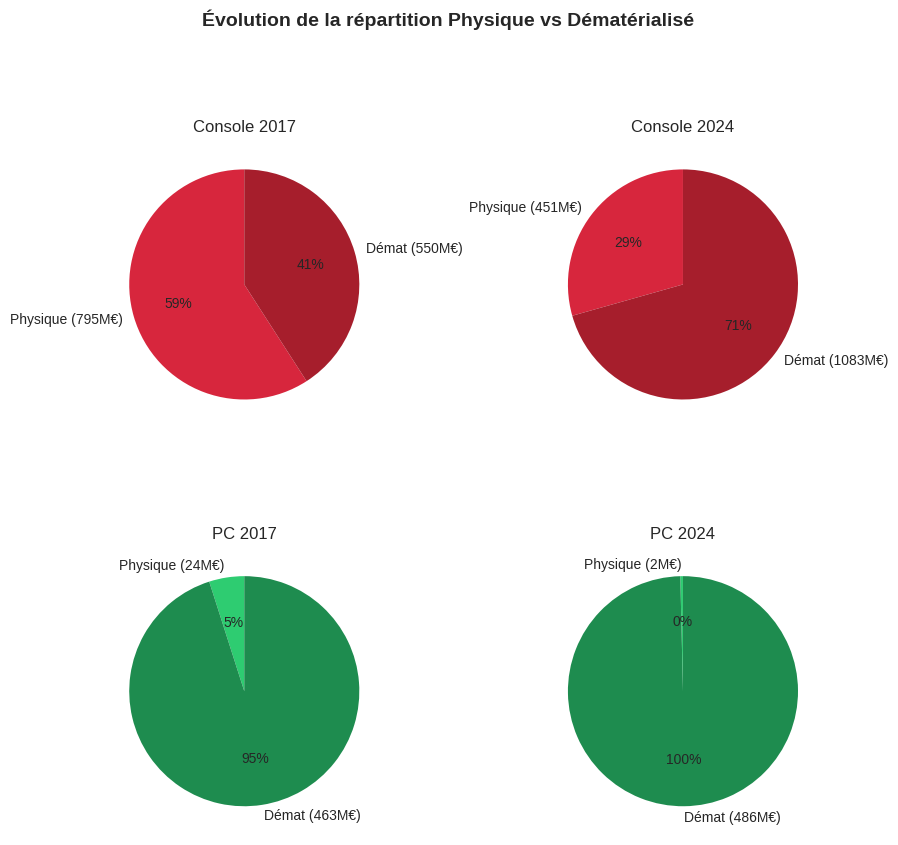

In [156]:
import matplotlib.pyplot as plt

# Choisir deux années à comparer
year1, year2 = 2017, 2024

# Récup valeurs pour Console
console_phys_2017 = console_phys[year_cols.index(year1)]
console_dem_2017  = console_dem[year_cols.index(year1)]
console_phys_2024 = console_phys[year_cols.index(year2)]
console_dem_2024  = console_dem[year_cols.index(year2)]

# Récup valeurs pour PC
pc_phys_2017 = pc_phys[year_cols.index(year1)]
pc_dem_2017  = pc_dem[year_cols.index(year1)]
pc_phys_2024 = pc_phys[year_cols.index(year2)]
pc_dem_2024  = pc_dem[year_cols.index(year2)]

# Couleurs
colors_console = ['#D7263D', '#A61E2C']  # physique / démat
colors_pc      = ['#2ECC71', '#1E8C4F']  # physique / démat

fig, axs = plt.subplots(2, 2, figsize=(9, 9))

# Console 2017
labels_console_2017 = [f"Physique ({console_phys_2017:.0f}M€)",
                       f"Démat ({console_dem_2017:.0f}M€)"]
axs[0, 0].pie([console_phys_2017, console_dem_2017],
              labels=labels_console_2017,
              autopct='%1.0f%%', colors=colors_console, startangle=90)
axs[0, 0].set_title(f"Console {year1}")

# Console 2024
labels_console_2024 = [f"Physique ({console_phys_2024:.0f}M€)",
                       f"Démat ({console_dem_2024:.0f}M€)"]
axs[0, 1].pie([console_phys_2024, console_dem_2024],
              labels=labels_console_2024,
              autopct='%1.0f%%', colors=colors_console, startangle=90)
axs[0, 1].set_title(f"Console {year2}")

# PC 2017
labels_pc_2017 = [f"Physique ({pc_phys_2017:.0f}M€)",
                  f"Démat ({pc_dem_2017:.0f}M€)"]
axs[1, 0].pie([pc_phys_2017, pc_dem_2017],
              labels=labels_pc_2017,
              autopct='%1.0f%%', colors=colors_pc, startangle=90)
axs[1, 0].set_title(f"PC {year1}")

# PC 2024
labels_pc_2024 = [f"Physique ({pc_phys_2024:.0f}M€)",
                  f"Démat ({pc_dem_2024:.0f}M€)"]
axs[1, 1].pie([pc_phys_2024, pc_dem_2024],
              labels=labels_pc_2024,
              autopct='%1.0f%%', colors=colors_pc, startangle=90)
axs[1, 1].set_title(f"PC {year2}")

plt.suptitle("Évolution de la répartition Physique vs Dématérialisé",
             fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Analyse des parts de marché par genre en France

In [157]:
#feuille genreconsole
df_France_genreConsole = df_France["genreConsole"]


# Extraire les en-têtes de la ligne
headers = df_France_genreConsole.iloc[45].tolist()
headers[0] = "Genre"
# Afficher les en-têtes extraits
print(f"\nEn-têtes extraits de la ligne 6: {headers}")
data_rows = df_France_genreConsole.iloc[46:60]



df_France_genreConsole_clean = pd.DataFrame(data_rows.values, columns=headers)
df_France_genreConsole_clean.columns = [
    int(col) if str(col).replace('.', '', 1).isdigit() else col
    for col in df_France_genreConsole_clean.columns
]
df_France_genreConsole_clean.head(16)


En-têtes extraits de la ligne 6: ['Genre', np.float64(2017.0), np.float64(2018.0), np.float64(2019.0), np.float64(2020.0), np.float64(2021.0), np.float64(2022.0), np.float64(2023.0), np.float64(2024.0)]


,Genre,2017,2018,2019,2020,2021,2022,2023,2024
0,action,20.293218,28.140021,21.105643,24.826571,22.41867,20.585483,20.851777,24.199474
1,sport,15.051155,15.203762,16.138263,16.28127,19.165488,20.842506,17.045424,20.121351
2,jeux de rôles,11.654889,9.655172,11.354012,11.078411,12.069778,18.145644,8.77677,10.039086
3,jeux de tir/FPS,22.613648,15.506792,16.115371,11.015346,12.694484,12.106811,9.196994,13.341893
4,aventure,9.018036,7.481714,11.743161,10.847173,9.087694,6.959984,25.311895,13.322531
5,stratégie/RTS,3.364624,2.716823,2.701156,8.39815,5.740217,4.363571,3.9715,3.227188
6,course,9.545407,7.742947,9.099233,7.641371,8.415842,9.629755,7.859013,6.807585
7,famille,2.826706,4.754441,4.498111,4.96111,5.928807,3.810268,2.891975,4.232796
8,combat,4.303344,6.959248,5.482431,3.447551,3.194248,2.439874,3.387601,3.924769
9,jeux casual,0.56956,0.668757,0.812636,0.861888,0.848656,0.658486,0.32921,0.252087


In [158]:

# Utilisation de pd.melt() pour pivoter le DataFrame
df_long = df_France_genreConsole_clean.melt(
    id_vars=['Genre'],  # La colonne qui ne doit pas être pivotée
    var_name='Année',   # Le nom de la nouvelle colonne pour les années
    value_name='Popularité' # Le nom de la nouvelle colonne pour les valeurs
)

# S'assurer que 'Année' est de type numérique pour un tri correct sur l'axe X
df_long['Année'] = pd.to_numeric(df_long['Année'])

print("Aperçu du DataFrame au format 'long':")
print(df_long.head())

Aperçu du DataFrame au format 'long':
             Genre  Année Popularité
0           action   2017  20.293218
1            sport   2017  15.051155
2    jeux de rôles   2017  11.654889
3  jeux de tir/FPS   2017  22.613648
4         aventure   2017   9.018036


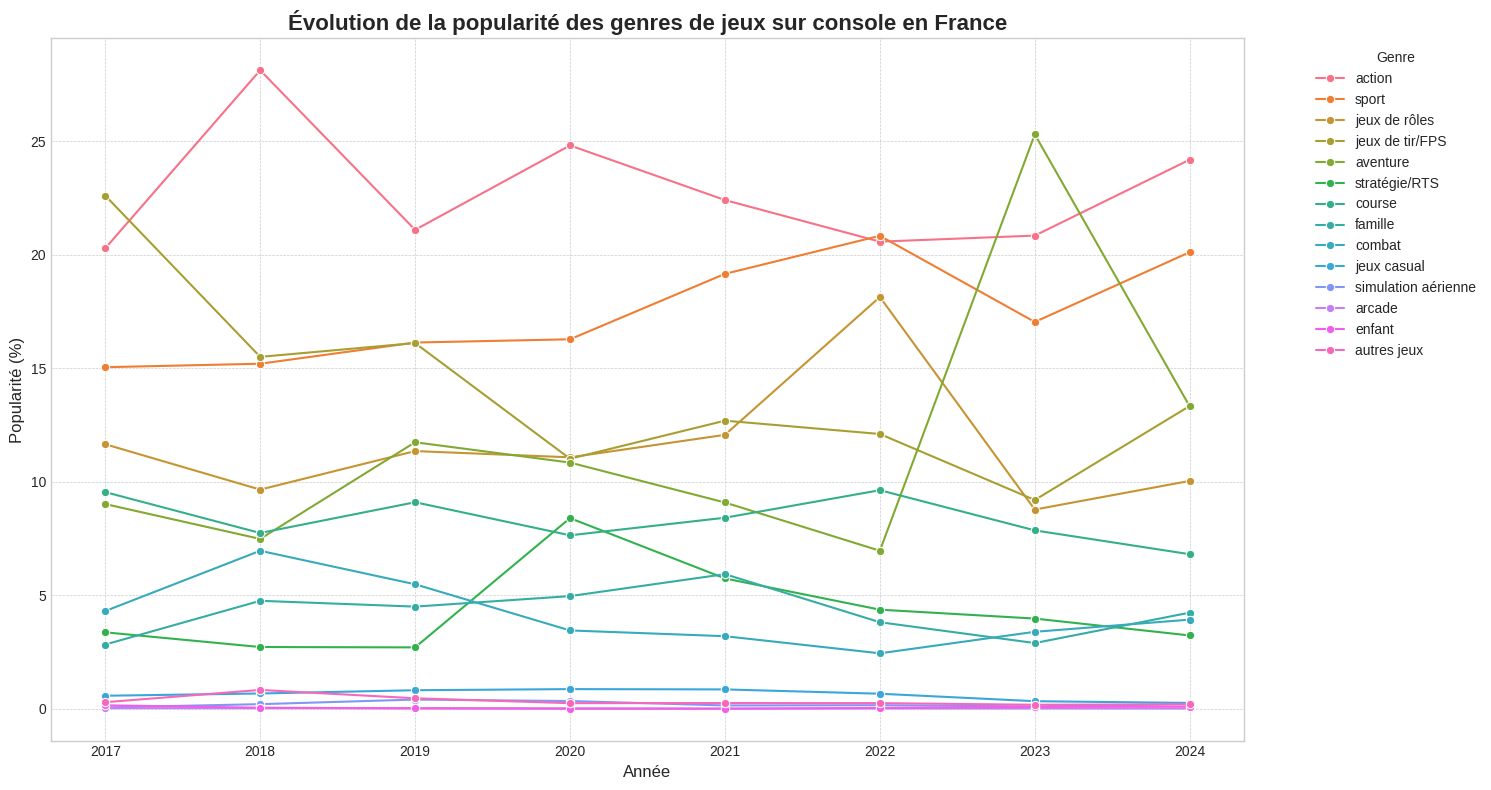

In [159]:
plt.figure(figsize=(15, 8))

sns.lineplot(
    data=df_long,
    x='Année',
    y='Popularité',
    hue='Genre',  # Crée une ligne de couleur différente pour chaque genre
    marker='o'    # Ajoute des points pour marquer chaque année
)

plt.title("Évolution de la popularité des genres de jeux sur console en France", fontsize=16, fontweight='bold')
plt.xlabel("Année", fontsize=12)
plt.ylabel("Popularité (%)", fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Placer la légende à l'extérieur du graphique pour plus de clarté
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout() # Ajuste automatiquement les paramètres pour que tout rentre
plt.show()

graphique a aire pour plus de lisibilité:

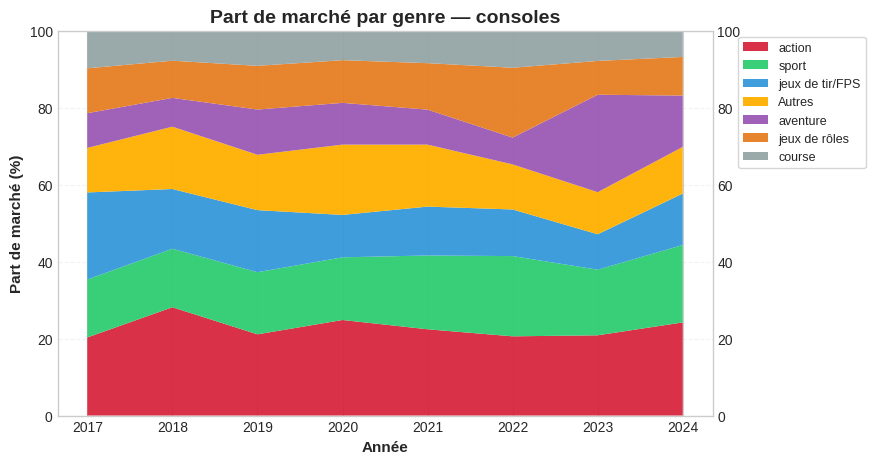

In [160]:

df = df_France_genreConsole_clean.copy()
df = df.rename(columns={df.columns[0]: 'Genre'}).set_index('Genre')
# la 1re colonne contient les genres, on la passe en index
if 'genre' in df.columns:
    df = df.rename(columns={df.columns[0]: 'genre'}).set_index('genre')

df = df.apply(pd.to_numeric, errors='coerce')


# Colonnes années en ordre
years = [int(c) for c in df.columns if str(c).isdigit()]
years = sorted(years)
df = df[years]

# On enlève les lignes toutes à zéro (ex: "arcade" si 0 partout)
df = df[df.max(axis=1) > 0]

# Graph A — Aire empilée 100% (Top 6 + Autres)
top_n = 6
means = df.mean(axis=1).sort_values(ascending=False)
top = list(means.head(top_n).index)
others = df.drop(index=top, errors='ignore').sum(axis=0)

df_plot = df.loc[top].copy()
df_plot.loc['Autres'] = others

# Palettes (6 + "Autres")
palette = ['#D7263D', '#2ECC71', '#3498DB', '#FFB000', '#9B59B6', '#E67E22', '#95A5A6']
order = df_plot.sum(axis=1).sort_values(ascending=False).index  # ordre légende

fig, ax = plt.subplots(figsize=(10, 5))

ax.stackplot(
    years,
    [df_plot.loc[g, years].values for g in order],
    labels=order,
    colors=palette[:len(order)],
    alpha=0.95
)

ax.set_title("Part de marché par genre — consoles", fontsize=14, fontweight='bold')
ax.set_xlabel("Année", fontsize=11, fontweight='bold')
ax.set_ylabel("Part de marché (%)", fontsize=11, fontweight='bold')
ax.set_xticks(years)
ax.set_xticklabels(years, rotation=0)
ax.set_ylim(0, 100)
ax.yaxis.set_ticks_position('both')
ax.tick_params(axis='y', right=True, labelright=True)
ax.spines['right'].set_visible(True)
ax.grid(axis='y', alpha=0.25, linestyle='--')
ax.legend(bbox_to_anchor=(1.03, 1), loc='upper left', frameon=True, fontsize=9)
fig.subplots_adjust(right=0.78)
plt.show()



In [161]:
df_France_genreConsole_clean.head()

,Genre,2017,2018,2019,2020,2021,2022,2023,2024
0,action,20.293218,28.140021,21.105643,24.826571,22.41867,20.585483,20.851777,24.199474
1,sport,15.051155,15.203762,16.138263,16.28127,19.165488,20.842506,17.045424,20.121351
2,jeux de rôles,11.654889,9.655172,11.354012,11.078411,12.069778,18.145644,8.77677,10.039086
3,jeux de tir/FPS,22.613648,15.506792,16.115371,11.015346,12.694484,12.106811,9.196994,13.341893
4,aventure,9.018036,7.481714,11.743161,10.847173,9.087694,6.959984,25.311895,13.322531


le même + prévisions

/tmp/ipython-input-1149633521.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: float(str(x).replace(',', '.')) if isinstance(x, str) else x)


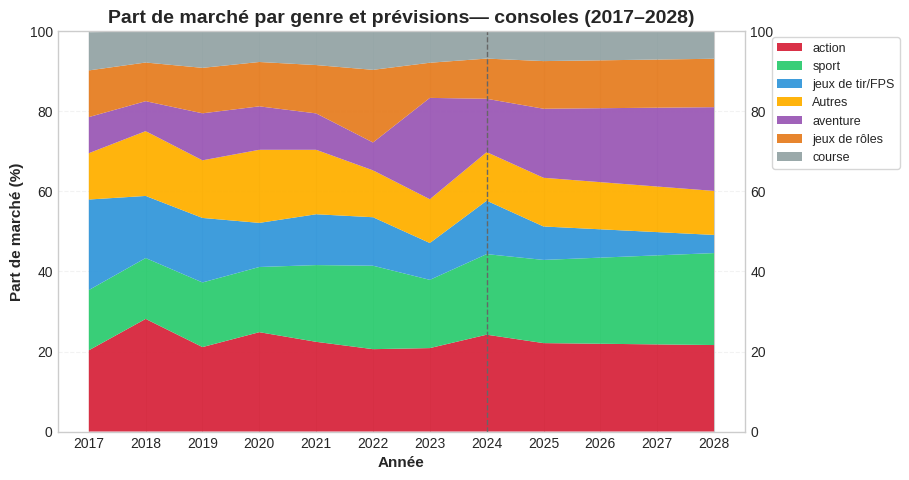

In [162]:


#Données historiques
df = df_France_genreConsole_clean.copy()
df = df.rename(columns={df.columns[0]: 'Genre'}).set_index('Genre')
if 'genre' in df.columns:  # sécurité si la 1re colonne s'appelle "genre"
    df = df.rename(columns={df.columns[0]: 'genre'}).set_index('genre')

# Nombres (gère les virgules)
df = df.applymap(lambda x: float(str(x).replace(',', '.')) if isinstance(x, str) else x)
df = df.apply(pd.to_numeric, errors='coerce')

years = sorted([int(c) for c in df.columns if str(c).isdigit()])
df = df[years]
df = df[df.max(axis=1) > 0]  # enlève lignes = 0

# Sélection Top 6 + "Autres" sur l'historique
top_n = 6
means = df.mean(axis=1).sort_values(ascending=False)
top = list(means.head(top_n).index)
others_hist = df.drop(index=top, errors='ignore').sum(axis=0)

df_plot = df.loc[top].copy()
df_plot.loc['Autres'] = others_hist

#Prévisions 2025–2028
hist_years = [y for y in years if y <= 2024]
fcst_years = list(range(2025, 2029))

# modèle par genre sur les parts (%) historiques
df_fcst = pd.DataFrame(index=df_plot.index, columns=fcst_years, dtype=float)

for g in df_plot.index:
    y_hist = df_plot.loc[g, hist_years].values.astype(float)
    x_hist = np.array(hist_years, dtype=float).reshape(-1, 1)

    model = LinearRegression()
    model.fit(x_hist, y_hist)

    x_fc = np.array(fcst_years, dtype=float).reshape(-1, 1)
    y_fc = model.predict(x_fc)
    y_fc = np.clip(y_fc, a_min=0, a_max=None)  # pas de négatifs
    df_fcst.loc[g, fcst_years] = y_fc

# Renormalisation (chaque année de 2025–2028 doit sommer 100 %)
col_sums = df_fcst.sum(axis=0)
col_sums = col_sums.replace(0, np.nan)  # garde-fou
df_fcst = df_fcst.div(col_sums, axis=1) * 100
df_fcst = df_fcst.fillna(0)

#aire empilée 100 % (historique + prévision)
# Palette & ordre
palette = ['#D7263D', '#2ECC71', '#3498DB', '#FFB000', '#9B59B6', '#E67E22', '#95A5A6']
order = df_plot.sum(axis=1).sort_values(ascending=False).index

all_years = hist_years + fcst_years
series_all = []
for g in order:
    hist_vals = df_plot.loc[g, hist_years].values
    fcst_vals = df_fcst.loc[g, fcst_years].values
    series_all.append(np.concatenate([hist_vals, fcst_vals]))

fig, ax = plt.subplots(figsize=(10.5, 5.2))

ax.stackplot(
    all_years,
    series_all,
    labels=order,
    colors=palette[:len(order)],
    alpha=0.95
)

# Marquer la zone de prévision
ax.axvline(x=2024, color='#666', linestyle='--', linewidth=1)

ax.set_title("Part de marché par genre et prévisions— consoles (2017–2028)", fontsize=14, fontweight='bold')
ax.set_xlabel("Année", fontsize=11, fontweight='bold')
ax.set_ylabel("Part de marché (%)", fontsize=11, fontweight='bold')
ax.set_xticks(all_years)
ax.set_xticklabels(all_years)
ax.set_ylim(0, 100)
ax.yaxis.set_ticks_position('both')
ax.tick_params(axis='y', right=True, labelright=True)
ax.spines['right'].set_visible(True)
ax.grid(axis='y', alpha=0.25, linestyle='--')

ax.legend(bbox_to_anchor=(1.03, 1), loc='upper left', frameon=True, fontsize=9)
fig.subplots_adjust(right=0.78)
plt.show()

on fait pareil pour la feuille genre PC (ne contient que les données de 2020 a 2024)

In [163]:
#feuille  genrepc
df_France_genrePC = df_France["genrePC"]

# Extraire les en-têtes de la ligne
headers = df_France_genrePC.iloc[45].tolist()
headers[0] = "Genre"
# Afficher les en-têtes extraits
print(f"\nEn-têtes extraits de la ligne 6: {headers}")
data_rows = df_France_genrePC.iloc[46:60]

df_France_genrePC_clean = pd.DataFrame(data_rows.values, columns=headers)
df_France_genrePC_clean.columns = [
    int(col) if str(col).replace('.', '', 1).isdigit() else col
    for col in df_France_genrePC_clean.columns
]
df_France_genrePC_clean.head(16)


En-têtes extraits de la ligne 6: ['Genre', 2017, 2018, 2019, np.float64(2020.0), np.float64(2021.0), np.float64(2022.0), np.float64(2023.0), np.float64(2024.0)]


,Genre,2017,2018,2019,2020,2021,2022,2023,2024
0,jeux de tir/FPS,-,-,-,25.060073,29.356452,27.158812,18.517316,27.606132
1,action,-,-,-,22.600891,15.613608,18.209594,15.8068,23.948889
2,jeux de rôles,-,-,-,12.159544,15.712295,17.475306,30.914403,17.523811
3,sport,-,-,-,6.589957,8.719446,10.540146,6.658841,9.746533
4,stratégie/RTS,-,-,-,20.403912,15.554207,12.63355,5.953016,7.197906
5,aventure,-,-,-,4.571708,5.009793,5.278425,14.406307,6.502551
6,course,-,-,-,2.953106,6.285289,5.831697,4.813862,4.402026
7,combat,-,-,-,0.989756,1.335747,1.181339,1.504951,1.555979
8,simulation aérienne,-,-,-,3.9537,1.681575,1.205541,1.165599,1.255823
9,autres jeux,-,-,-,0.063394,0.080616,0.063385,0.029523,0.12562


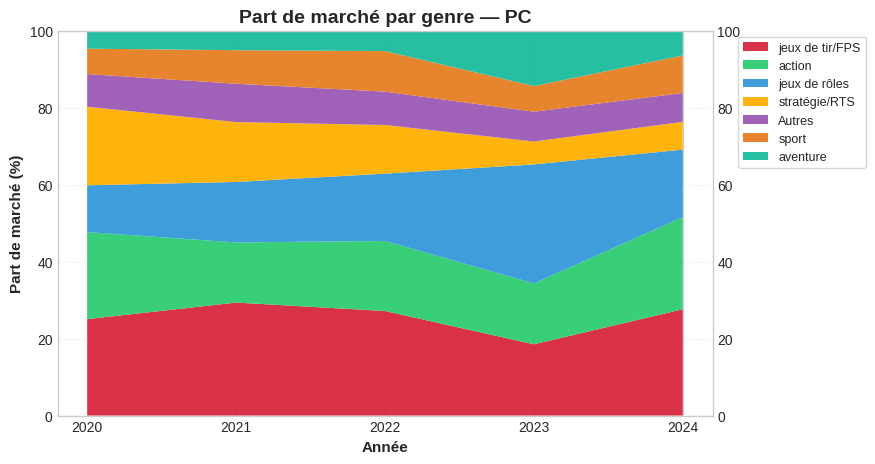

In [164]:
import unicodedata

df = df_France_genrePC_clean.copy()
#supprimer les premieres années manquantes
df = df.drop(columns=[2017,2018,2019])
df = df.rename(columns={df.columns[0]: 'Genre'}).set_index('Genre')
# Si la 1re colonne contient les genres, on la passe en index
if 'genre' in df.columns:
    df = df.rename(columns={df.columns[0]: 'genre'}).set_index('genre')

df = df.apply(pd.to_numeric, errors='coerce')


# Colonnes années en ordre
years = [int(c) for c in df.columns if str(c).isdigit()]
years = sorted(years)
df = df[years]

# On enlève les lignes toutes à zéro
df = df[df.max(axis=1) > 0]

#on va forcer la couleur pour etre identique a console

def normalize(s: str) -> str:
    s = unicodedata.normalize('NFKD', s).encode('ascii', 'ignore').decode('ascii')
    return s.strip().lower()

forced = {
    'action': '#D7263D',         # rouge
    'aventure': '#9B59B6',       # violet
    'jeux de roles': '#E67E22',  # orange
    'jeux de tir/fps': '#3498DB',  # bleu
    'sport': '#2ECC71',  # vert
    'strategie/rts': '#95A5A6',  # gris

}

# Couleurs par défaut pour les autres
fallback = ['#1ABC9C', '#F39C12', '#34495E']

# Couleur pour "Autres"
autres_color = '#FFB000'

# Construire la liste de couleurs alignée sur 'order'
colors_for_order = []
used = set(forced.values())
fb_iter = iter([c for c in fallback if c not in used])

for g in order:
    ng = normalize(g)
    if g == 'Autres':
        colors_for_order.append(autres_color)
    elif ng in forced:
        colors_for_order.append(forced[ng])
    else:
        # couleur suivante dispo
        colors_for_order.append(next(fb_iter, '#7F8C8D'))




#on prends que les 6 premiers genres

top_n = 6
means = df.mean(axis=1).sort_values(ascending=False)
top = list(means.head(top_n).index)
others = df.drop(index=top, errors='ignore').sum(axis=0)

df_plot = df.loc[top].copy()
df_plot.loc['Autres'] = others

# Palettes (6 + "Autres")
palette = ['#D7263D', '#2ECC71', '#3498DB', '#FFB000', '#9B59B6', '#E67E22', '#95A5A6']
order = df_plot.sum(axis=1).sort_values(ascending=False).index  # ordre légende

fig, ax = plt.subplots(figsize=(10, 5))
ax.stackplot(
    years,
    [df_plot.loc[g, years].values for g in order],
    labels=order,
    colors=colors_for_order,
    alpha=0.95
)

ax.set_title("Part de marché par genre — PC", fontsize=14, fontweight='bold')
ax.set_xlabel("Année", fontsize=11, fontweight='bold')
ax.set_ylabel("Part de marché (%)", fontsize=11, fontweight='bold')
ax.set_xticks(years)
ax.set_xticklabels(years, rotation=0)
ax.set_ylim(0, 100)
ax.yaxis.set_ticks_position('both')
ax.tick_params(axis='y', right=True, labelright=True)
ax.spines['right'].set_visible(True)
ax.grid(axis='y', alpha=0.25, linestyle='--')
ax.legend(bbox_to_anchor=(1.03, 1), loc='upper left', frameon=True, fontsize=9)
fig.subplots_adjust(right=0.78)
plt.show()



on fait les previsions pour pc

/tmp/ipython-input-277012725.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: float(str(x).replace(',', '.')) if isinstance(x, str) else x)


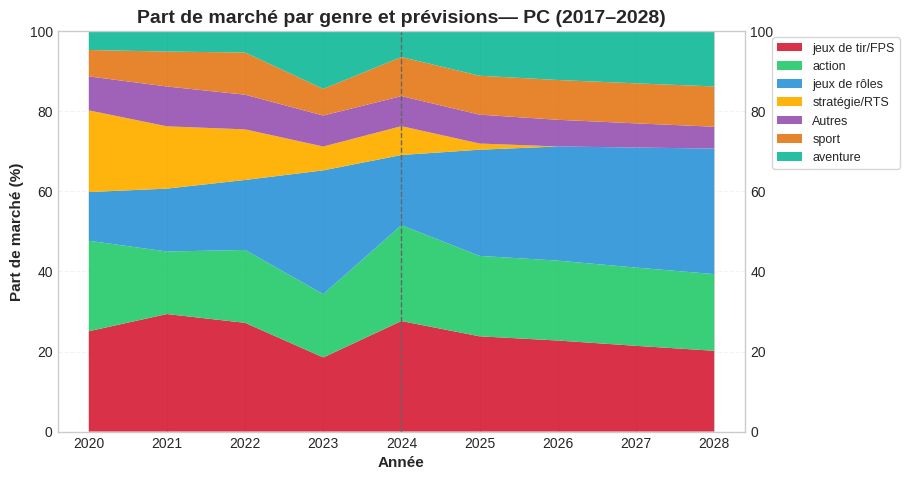

In [165]:


df = df_France_genrePC_clean.copy()
#supprimer les premieres années manquantes
df = df.drop(columns=[2017,2018,2019])
df = df.rename(columns={df.columns[0]: 'Genre'}).set_index('Genre')
if 'genre' in df.columns:  # sécurité si la 1re colonne s'appelle "genre"
    df = df.rename(columns={df.columns[0]: 'genre'}).set_index('genre')

# Nombres (gère les virgules)
df = df.applymap(lambda x: float(str(x).replace(',', '.')) if isinstance(x, str) else x)
df = df.apply(pd.to_numeric, errors='coerce')

years = sorted([int(c) for c in df.columns if str(c).isdigit()])
df = df[years]
df = df[df.max(axis=1) > 0]  # enlève lignes = 0

#on va forcer la couleur pour etre identique a console

def normalize(s: str) -> str:
    s = unicodedata.normalize('NFKD', s).encode('ascii', 'ignore').decode('ascii')
    return s.strip().lower()

forced = {
    'action': '#D7263D',         # rouge
    'aventure': '#9B59B6',       # violet
    'jeux de roles': '#E67E22',  # orange
    'jeux de tir/fps': '#3498DB',  # bleu
    'sport': '#2ECC71',  # vert
    'strategie/rts': '#95A5A6',  # gris

}

# Couleurs par défaut pour les autres
fallback = ['#1ABC9C', '#F39C12', '#34495E']

# Couleur pour "Autres"
autres_color = '#FFB000'



# Sélection Top 6 + "Autres" sur l'historique
top_n = 6
means = df.mean(axis=1).sort_values(ascending=False)
top = list(means.head(top_n).index)
others_hist = df.drop(index=top, errors='ignore').sum(axis=0)

df_plot = df.loc[top].copy()
df_plot.loc['Autres'] = others_hist

# Prévisions 2025–2028 (linéaire)
hist_years = [y for y in years if y <= 2024]
fcst_years = list(range(2025, 2029))

# modèle par genre sur les parts (%) historiques
df_fcst = pd.DataFrame(index=df_plot.index, columns=fcst_years, dtype=float)

for g in df_plot.index:
    y_hist = df_plot.loc[g, hist_years].values.astype(float)
    x_hist = np.array(hist_years, dtype=float).reshape(-1, 1)

    model = LinearRegression()
    model.fit(x_hist, y_hist)

    x_fc = np.array(fcst_years, dtype=float).reshape(-1, 1)
    y_fc = model.predict(x_fc)
    y_fc = np.clip(y_fc, a_min=0, a_max=None)  # pas de négatifs
    df_fcst.loc[g, fcst_years] = y_fc

# Renormalisation (chaque année de 2025–2028 doit sommer 100 %)
col_sums = df_fcst.sum(axis=0)
col_sums = col_sums.replace(0, np.nan)
df_fcst = df_fcst.div(col_sums, axis=1) * 100
df_fcst = df_fcst.fillna(0)

# aire empilée 100 % (historique + prévision)
# Palette & ordre (on garde l’ordre par importance historique)
palette = ['#D7263D', '#2ECC71', '#3498DB', '#FFB000', '#9B59B6', '#E67E22', '#95A5A6']
order = df_plot.sum(axis=1).sort_values(ascending=False).index

all_years = hist_years + fcst_years
series_all = []
for g in order:
    hist_vals = df_plot.loc[g, hist_years].values
    fcst_vals = df_fcst.loc[g, fcst_years].values
    series_all.append(np.concatenate([hist_vals, fcst_vals]))

fig, ax = plt.subplots(figsize=(10.5, 5.2))

ax.stackplot(
    all_years,
    series_all,
    labels=order,
    colors=colors_for_order,
    alpha=0.95
)



# Marquer la zone de prévision
ax.axvline(x=2024, color='#666', linestyle='--', linewidth=1)


ax.set_title("Part de marché par genre et prévisions— PC (2017–2028)", fontsize=14, fontweight='bold')
ax.set_xlabel("Année", fontsize=11, fontweight='bold')
ax.set_ylabel("Part de marché (%)", fontsize=11, fontweight='bold')
ax.set_xticks(all_years)
ax.set_xticklabels(all_years)
ax.set_ylim(0, 100)
ax.yaxis.set_ticks_position('both')
ax.tick_params(axis='y', right=True, labelright=True)
ax.spines['right'].set_visible(True)
ax.grid(axis='y', alpha=0.25, linestyle='--')

ax.legend(bbox_to_anchor=(1.03, 1), loc='upper left', frameon=True, fontsize=9)
fig.subplots_adjust(right=0.78)
plt.show()


Analyse des ventes suivant le PEGI

In [166]:
#feuille  PEGIConsole et PEGIPC
df_France_PEGIconsoles = df_France["PEGIConsole"]
df_France_PEGIPC = df_France["PEGIPC"]


# Extraire les en-têtes de la ligne
headers = df_France_PEGIconsoles.iloc[17].tolist()
headers2 = df_France_PEGIPC.iloc[17].tolist()
headers[0] = "pegi"
headers2[0] = "pegi"
# Afficher les en-têtes extraits
print(f"\nEn-têtes extraits de la ligne 6: {headers}")
print(f"\nEn-têtes extraits de la ligne 6: {headers2}")
data_rows = df_France_PEGIconsoles.iloc[18:23]
data_rows2 = df_France_PEGIPC.iloc[18:23]


df_France_PEGIconsoles = pd.DataFrame(data_rows.values, columns=headers)
df_France_PEGIconsoles.columns = [
    int(col) if str(col).replace('.', '', 1).isdigit() else col
    for col in df_France_PEGIconsoles.columns
]


df_France_PEGIPC = pd.DataFrame(data_rows2.values, columns=headers)
df_France_PEGIPC.columns = [
    int(col) if str(col).replace('.', '', 1).isdigit() else col
    for col in df_France_PEGIconsoles.columns
]

df_France_PEGIconsoles = df_France_PEGIconsoles.set_index('pegi')
df_France_PEGIPC = df_France_PEGIPC.set_index('pegi')
#remplacer le signe "-" par 0
df_France_PEGIPC = df_France_PEGIPC.replace('-', 0)
df_France_PEGIconsoles=df_France_PEGIconsoles.astype(float)
df_France_PEGIPC=df_France_PEGIPC.astype(float)



df_France_PEGIPC.columns=df_France_PEGIPC.columns.astype(int)
df_France_PEGIconsoles.columns=df_France_PEGIconsoles.columns.astype(int)



display(df_France_PEGIPC)
df_France_PEGIPC.info()


# on va créer un tableau global
df_pegi=df_France_PEGIPC+df_France_PEGIconsoles
#supprimer les colonnes 2016,2017,2018,2019 car données pc non disponibles
df_pegi=df_pegi.drop(columns=[2016,2017,2018,2019])

df_pegi.head()



En-têtes extraits de la ligne 6: ['pegi', np.float64(2016.0), np.float64(2017.0), np.float64(2018.0), np.float64(2019.0), np.float64(2020.0), np.float64(2021.0), np.float64(2022.0), np.float64(2023.0), np.float64(2024.0)]

En-têtes extraits de la ligne 6: ['pegi', 2016, 2017, 2018, 2019, np.float64(2020.0), np.float64(2021.0), np.float64(2022.0), np.float64(2023.0), np.float64(2024.0)]


/tmp/ipython-input-3432515053.py:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_France_PEGIPC = df_France_PEGIPC.replace('-', 0)


,2016,2017,2018,2019,2020,2021,2022,2023,2024
pegi,,,,,,,,,
3 ans et plus,0.0,0.0,0.0,0.0,12565771.77,16234014.89,16113443.64,13729627.64,15375679.08
7 ans et plus,0.0,0.0,0.0,0.0,3350168.21,3289760.99,3114110.35,3280696.60,2801585.25
12 ans et plus,0.0,0.0,0.0,0.0,21345652.86,16256593.43,13767720.41,23613555.67,15733363.99
16 ans et plus,0.0,0.0,0.0,0.0,15369603.43,16104312.01,21140720.42,13712873.20,19139776.63
18 ans et plus,0.0,0.0,0.0,0.0,48058254.27,43805581.58,39872784.01,66646277.32,47691866.60


<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 3 ans et plus to 18 ans et plus
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2016    5 non-null      float64
 1   2017    5 non-null      float64
 2   2018    5 non-null      float64
 3   2019    5 non-null      float64
 4   2020    5 non-null      float64
 5   2021    5 non-null      float64
 6   2022    5 non-null      float64
 7   2023    5 non-null      float64
 8   2024    5 non-null      float64
dtypes: float64(9)
memory usage: 400.0+ bytes


,2020,2021,2022,2023,2024
pegi,,,,,
3 ans et plus,3.606075e+08,3.663392e+08,3.219485e+08,3.204310e+08,2.735096e+08
7 ans et plus,1.393529e+08,1.350256e+08,2.034982e+08,9.281341e+07,1.009000e+08
12 ans et plus,1.298579e+08,1.182462e+08,8.457385e+07,2.322539e+08,1.266392e+08
16 ans et plus,8.200882e+07,8.086494e+07,1.205955e+08,1.212930e+08,1.125719e+08
18 ans et plus,3.376977e+08,2.417114e+08,2.390292e+08,2.713848e+08,2.487958e+08


In [167]:
df=df_pegi
df = df.astype(float)

# Convertir les noms des colonnes en type numérique (int).
df.columns = df.columns.astype(int)
df = df / 1_000_000
df_long = df.reset_index().melt(
    id_vars='pegi',
    var_name='Année',
    value_name='Revenus (M€)'
)
df_long['Année'] = pd.to_numeric(df_long['Année'])

print("Aperçu du DataFrame après transformation (format long) :")
print(df_long.head())
print(df.info())


Aperçu du DataFrame après transformation (format long) :
             pegi  Année  Revenus (M€)
0   3 ans et plus   2020    360.607484
1   7 ans et plus   2020    139.352938
2  12 ans et plus   2020    129.857885
3  16 ans et plus   2020     82.008819
4  18 ans et plus   2020    337.697710
<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 3 ans et plus to 18 ans et plus
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2020    5 non-null      float64
 1   2021    5 non-null      float64
 2   2022    5 non-null      float64
 3   2023    5 non-null      float64
 4   2024    5 non-null      float64
dtypes: float64(5)
memory usage: 240.0+ bytes
None


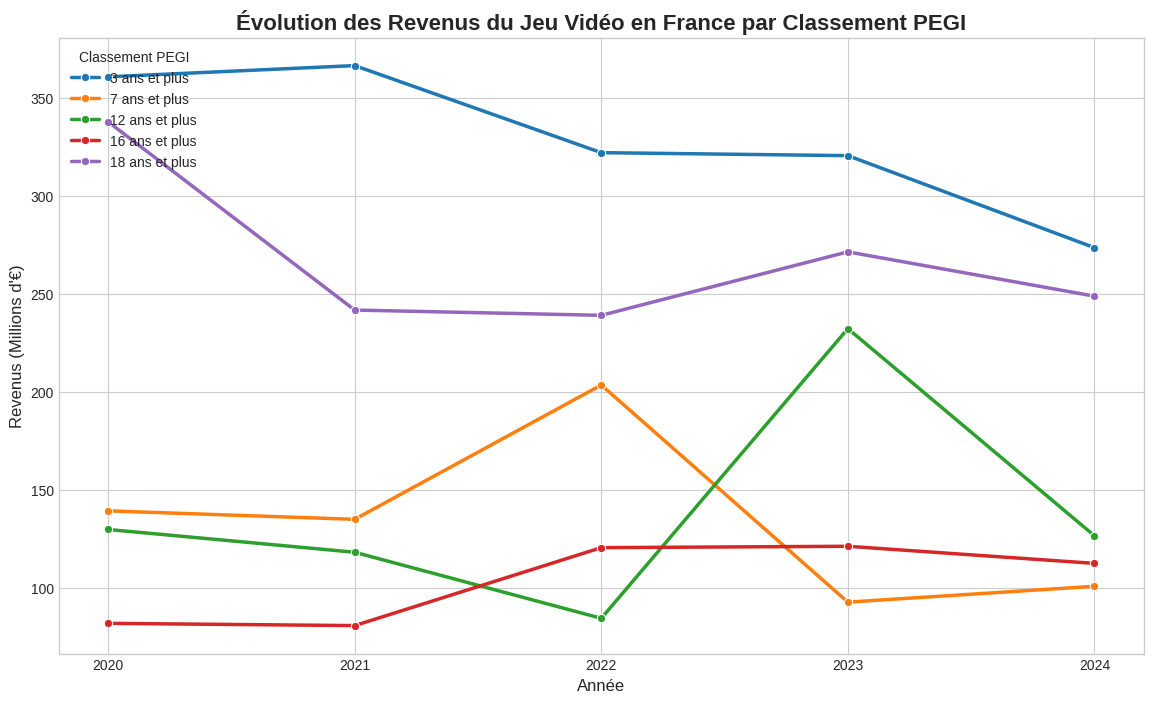

In [168]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 8))

sns.lineplot(
    data=df_long,
    x='Année',
    y='Revenus (M€)',
    hue='pegi', # Une couleur par catégorie PEGI
    marker='o',
    linewidth=2.5
)

plt.title("Évolution des Revenus du Jeu Vidéo en France par Classement PEGI", fontsize=16, fontweight='bold')
plt.xlabel("Année", fontsize=12)
plt.ylabel("Revenus (Millions d'€)", fontsize=12)
plt.legend(title="Classement PEGI", loc='upper left')
plt.xticks(df_long['Année'].unique()) # S'assurer que chaque année est affichée
plt.show()

test avec graphique a aire empilée

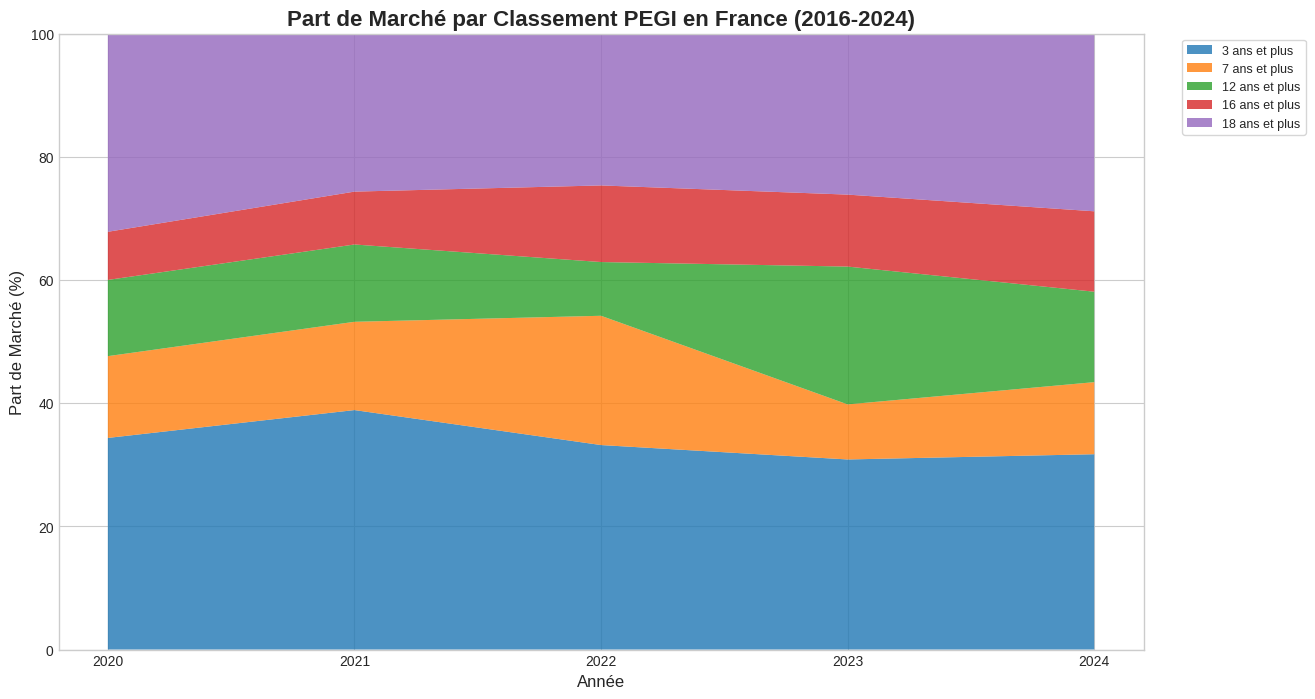

In [169]:
# On calcule les pourcentages à partir du DataFrame original

df_percent = df.div(df.sum(axis=0), axis=1) * 100
df_percent.columns.astype(int)

plt.figure(figsize=(14, 8))
plt.stackplot(
    df_percent.columns,
    df_percent.values,
    labels=df_percent.index,
    alpha=0.8
)

plt.title("Part de Marché par Classement PEGI en France (2016-2024)", fontsize=16, fontweight='bold')
plt.xlabel("Année", fontsize=12)
plt.ylabel("Part de Marché (%)", fontsize=12)
plt.ylim(0, 100)
plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', frameon=True, fontsize=9)
plt.xticks(df_percent.columns.astype(int))
plt.show()


graphique revenu annuel moyen par PEGI

/tmp/ipython-input-4242251173.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


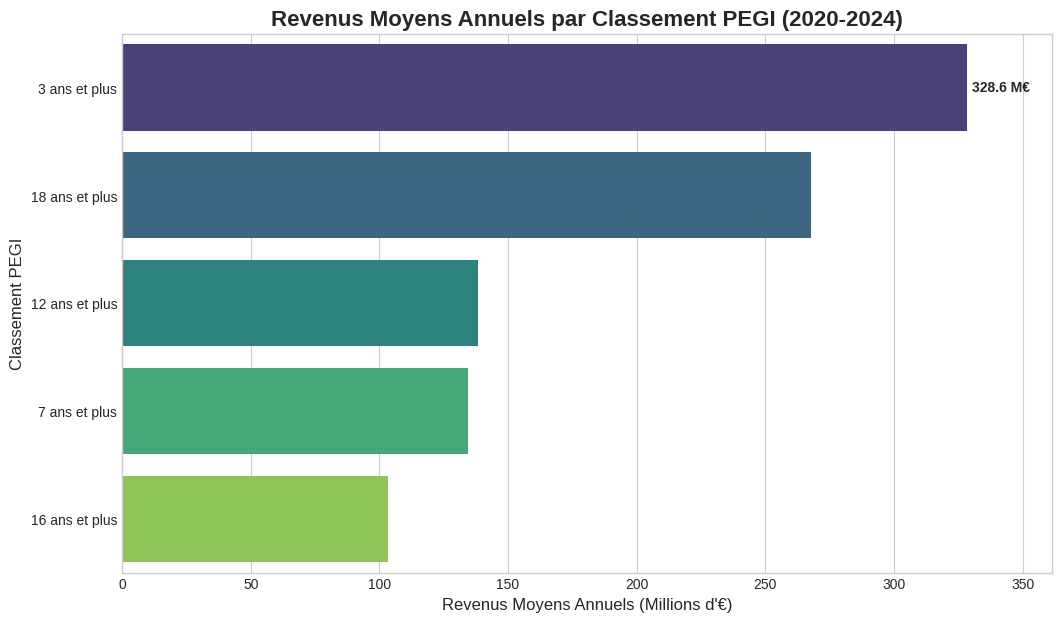

In [170]:
# Calculer la moyenne des revenus pour chaque catégorie
mean_revenues = df.mean(axis=1).sort_values(ascending=False)

plt.figure(figsize=(12, 7))
ax = sns.barplot(
    x=mean_revenues.values,
    y=mean_revenues.index,
    palette='viridis',
    orient='h'
)

# Ajouter les valeurs sur les barres
ax.bar_label(ax.containers[0], fmt='%.1f M€', padding=3, fontsize=10, fontweight='bold')

plt.title("Revenus Moyens Annuels par Classement PEGI (2020-2024)", fontsize=16, fontweight='bold')
plt.xlabel("Revenus Moyens Annuels (Millions d'€)", fontsize=12)
plt.ylabel("Classement PEGI", fontsize=12)
plt.xlim(0, mean_revenues.max() * 1.1) # Laisser de l'espace pour les labels
plt.show()

Les données du PEGI ne peuvent pas dicter le devellopement et la vision du AAA, elles ne renseignent aps du nombre de jeux qui se partagent les revenus. LEs jeux 3+ sont les plus hauts en revenus, mais ils y a enormément de jeux familiaux dans cette catégorie, garantissant un revenu à l'unité plus faible. Je n'ai aps les données PEGI par titres, donc non exploitable. Ce qui est certain c'est que pour un AAA, on va viser une aventure narrative complexe, ce qui sera du genre 16+ (si possible) ou 18+